### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.68 s, sys: 181 ms, total: 6.86 s
Wall time: 11.3 s


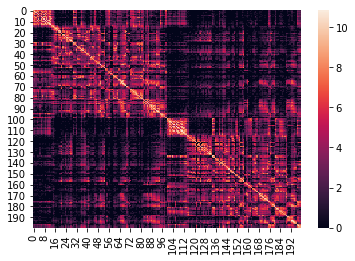

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [24]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [25]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

In [31]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [32]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [33]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [34]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

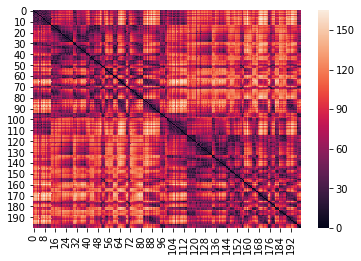

In [35]:
sns.heatmap(distance)

In [36]:
import scipy.linalg
import scipy.sparse


In [37]:
def communicability_wei_v2(CIJ):
    
    """
    Calculate communicability for a weighted connection matrix CIJ.
    
    Inputs:
    CIJ - weighted connection matrix
    
    Output:
    F - communicability matrix
    
    Note: This time, we don't normalize using scipy.linalg.expm(S^(1/2)*SC*S^(1/2)),
    where S is the diagonal matrix. 
    This is because pre-/post- SC lesion, the diagonals are different for the different SCs. 
    """
    
    N = CIJ.shape[0]
    min_val = np.min(CIJ)
    max_val = np.max(CIJ)
    scaled_matrix = (CIJ - min_val) / (max_val - min_val)
    
    F = scipy.linalg.expm(scaled_matrix)
    F = F * np.logical_not(np.eye(N))
    
    return F


## Communicability

In [38]:
# intact sc

In [39]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei_v2(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 3.53 s, sys: 93 ms, total: 3.62 s
Wall time: 3.62 s


In [40]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [41]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [42]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 103 ms, sys: 207 ms, total: 310 ms
Wall time: 308 ms


In [43]:
# lesion sc

In [44]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei_v2(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei_v2(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei_v2(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei_v2(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei_v2(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei_v2(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei_v2(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 24.5 s, sys: 361 ms, total: 24.8 s
Wall time: 24.8 s


## WITHIN NETWORKS

In [45]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    
    return mean_sc

In [46]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [47]:
intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [48]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [49]:
all_sc_comm_means = [intact_sc_comm_means,
vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [56]:
ntwx_sc_comm_means = [vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [55]:
percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_comm_means,vis_lesion_sc_comm_means)]
print(percent_change)
            

[-1.1516130432050515, -0.01313304923115593, -1.7174879728357764, -0.05341965569852506, -1.0460503593931, -0.1556067449806449, -0.4416792887418587]


In [58]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_comm_means,ntwx_sc_comm_means[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [84]:
# percent_change_all_ntwx

In [63]:
hex_codes = ['#781286', '#4682B4', '#00760E', '#C43AFA', '#DCF8A4', '#E69422', '#CD3E4E']

In [68]:
Ntwx_labels = ['blah', 'Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

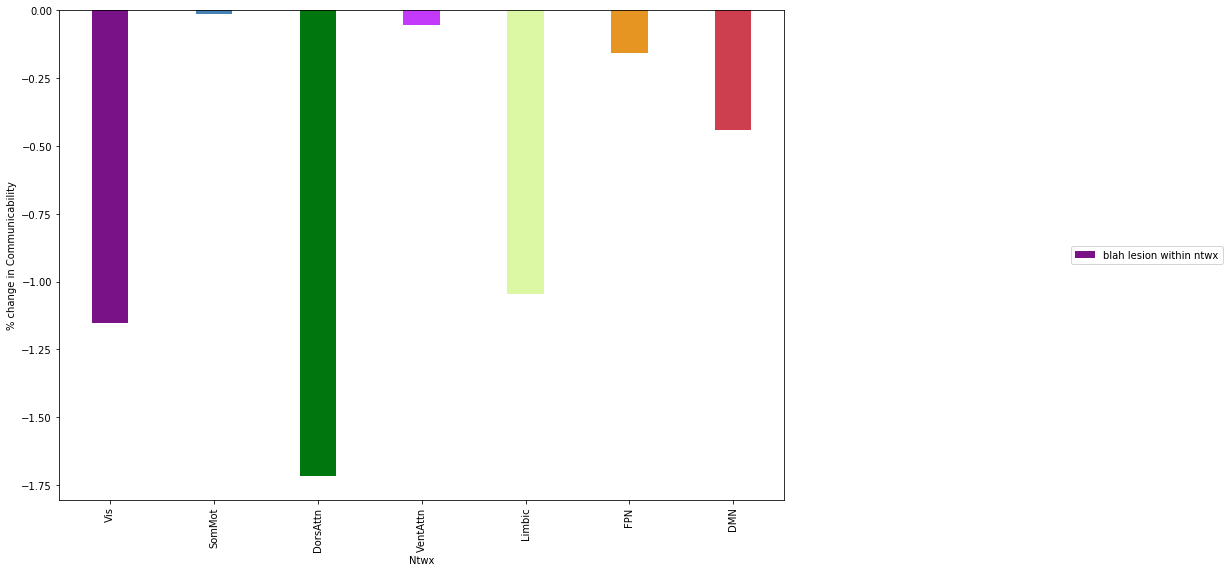

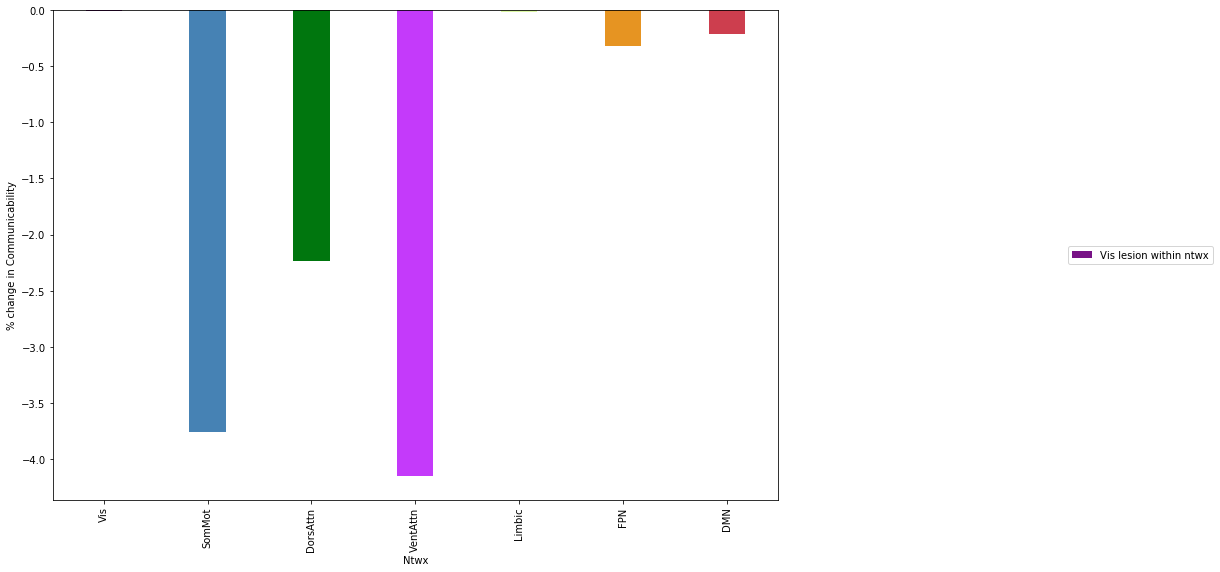

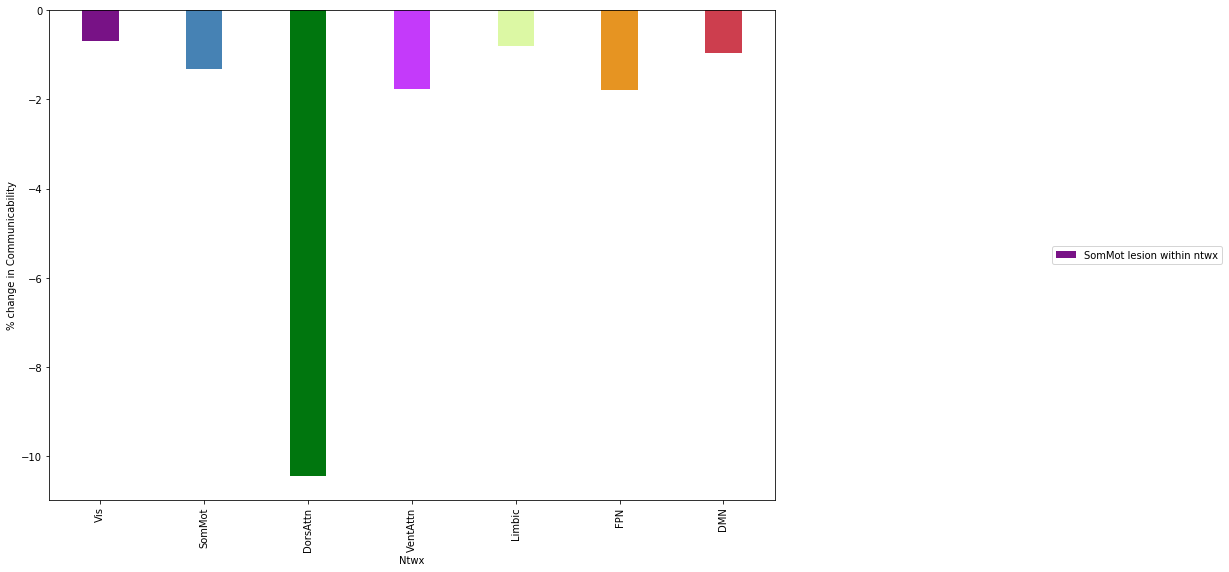

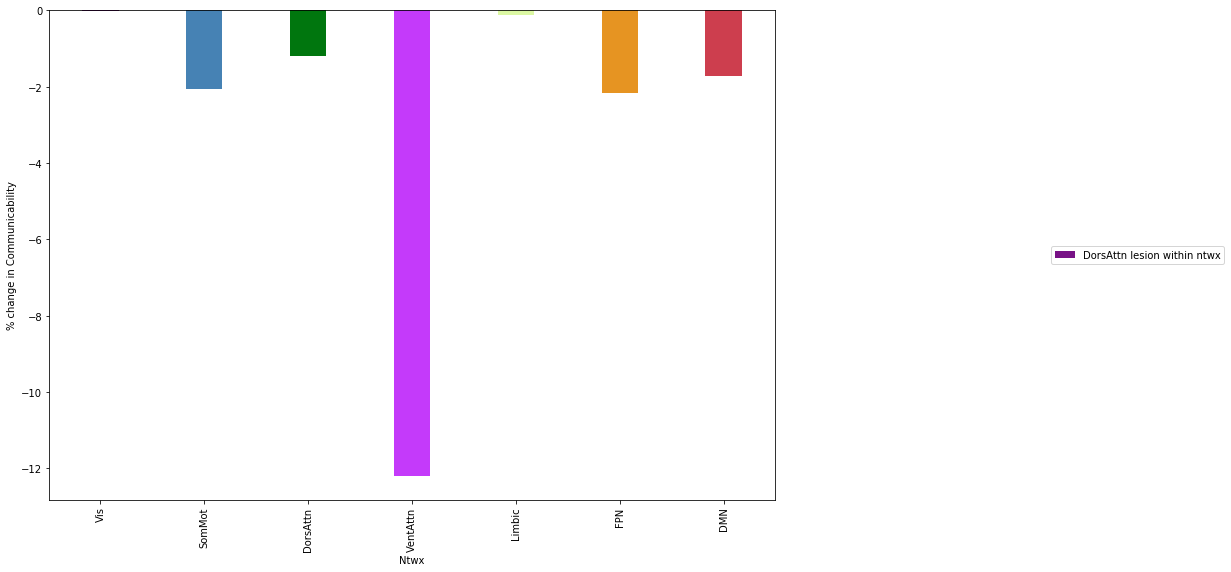

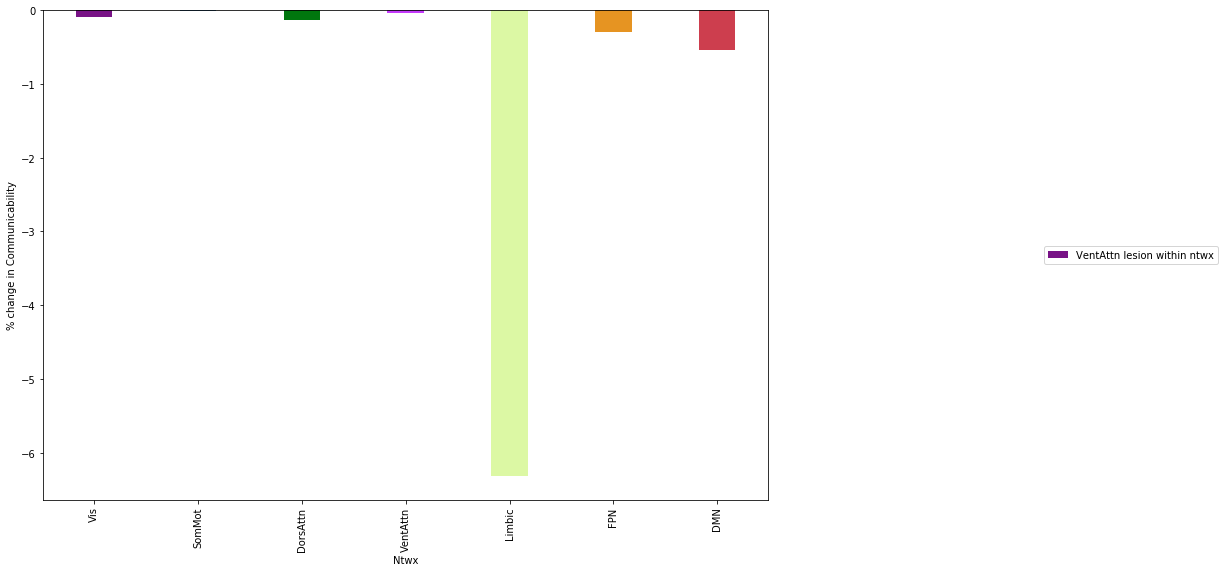

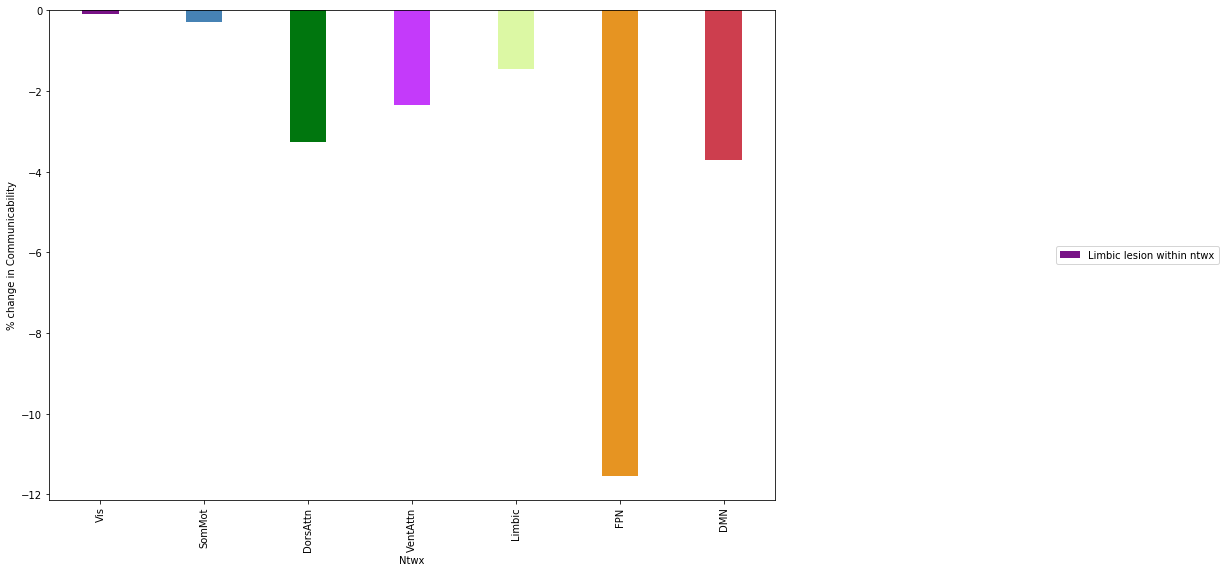

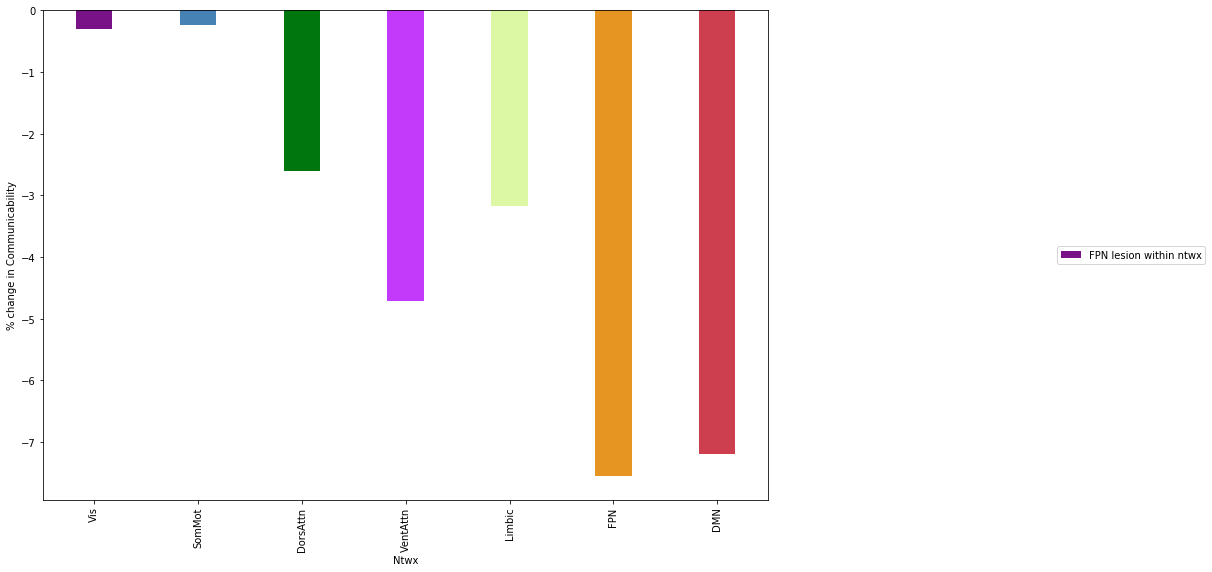

In [69]:
x = range(len(intact_sc_comm_means))
width = 0.35
for i in range(7):
    fig, ax = plt.subplots(figsize=(13,9))
    rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='{0} lesion within ntwx'.format(Ntwx_labels[i]),color=hex_codes)
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('% change in Communicability')
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

## =============================================================

#  BETWEEN NTWX

In [521]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_smt = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_smt = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dan = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dan = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_van = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_van = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_lim = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_lim = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_smt = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_smt = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dan = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dan = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_van = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_van = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_lim = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_lim = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)#/4
    mean_ntwx_to_smt_sc = ((np.mean(lh_ntwx_to_lh_smt) + np.mean(rh_ntwx_to_rh_smt))/2 + (np.mean(lh_ntwx_to_rh_smt) + np.mean(rh_ntwx_to_lh_smt))/2)#/4
    mean_ntwx_to_dan_sc = ((np.mean(lh_ntwx_to_lh_dan) + np.mean(rh_ntwx_to_rh_dan))/2 + (np.mean(lh_ntwx_to_rh_dan) + np.mean(rh_ntwx_to_lh_dan))/2)#/4
    mean_ntwx_to_van_sc = ((np.mean(lh_ntwx_to_lh_van) + np.mean(rh_ntwx_to_rh_van))/2 + (np.mean(lh_ntwx_to_rh_van) + np.mean(rh_ntwx_to_lh_van))/2)#/4
    mean_ntwx_to_lim_sc = ((np.mean(lh_ntwx_to_lh_lim) + np.mean(rh_ntwx_to_rh_lim))/2 + (np.mean(lh_ntwx_to_rh_lim) + np.mean(rh_ntwx_to_lh_lim))/2)#/4
    mean_ntwx_to_fpn_sc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)#/4
    mean_ntwx_to_dmn_sc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)#/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_smt_sc, mean_ntwx_to_dan_sc, mean_ntwx_to_van_sc, mean_ntwx_to_lim_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [522]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [523]:
def get_between_ntwx_sc_communicability_all_subs(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        

    return  all_subs_vis_to_other_ntwx_lesions, all_subs_smt_to_other_ntwx_lesions, all_subs_dan_to_other_ntwx_lesions, all_subs_van_to_other_ntwx_lesions, all_subs_lim_to_other_ntwx_lesions, all_subs_fpn_to_other_ntwx_lesions, all_subs_dmn_to_other_ntwx_lesions

In [524]:
def get_between_ntwx_sc_communicability_std(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    std_all_subs_vis_to_other_ntwx_lesions = np.std(all_subs_vis_to_other_ntwx_lesions,axis=0)
    std_all_subs_smt_to_other_ntwx_lesions = np.std(all_subs_smt_to_other_ntwx_lesions,axis=0)
    std_all_subs_dan_to_other_ntwx_lesions = np.std(all_subs_dan_to_other_ntwx_lesions,axis=0)
    std_all_subs_van_to_other_ntwx_lesions = np.std(all_subs_van_to_other_ntwx_lesions,axis=0)
    std_all_subs_lim_to_other_ntwx_lesions = np.std(all_subs_lim_to_other_ntwx_lesions,axis=0)
    std_all_subs_fpn_to_other_ntwx_lesions = np.std(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    std_all_subs_dmn_to_other_ntwx_lesions = np.std(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return std_all_subs_vis_to_other_ntwx_lesions,std_all_subs_smt_to_other_ntwx_lesions,std_all_subs_dan_to_other_ntwx_lesions,std_all_subs_van_to_other_ntwx_lesions,std_all_subs_lim_to_other_ntwx_lesions,std_all_subs_fpn_to_other_ntwx_lesions,std_all_subs_dmn_to_other_ntwx_lesions

In [520]:
all_subs_communicability_sc

[array([[0.        , 0.11421805, 0.01764232, ..., 0.00058738, 0.00039634,
         0.00027795],
        [0.11421805, 0.        , 0.0833625 , ..., 0.00193614, 0.00109342,
         0.00072347],
        [0.01764232, 0.0833625 , 0.        , ..., 0.00073158, 0.00041667,
         0.00032629],
        ...,
        [0.00058738, 0.00193614, 0.00073158, ..., 0.        , 0.14840195,
         0.02977041],
        [0.00039634, 0.00109342, 0.00041667, ..., 0.14840195, 0.        ,
         0.15212123],
        [0.00027795, 0.00072347, 0.00032629, ..., 0.02977041, 0.15212123,
         0.        ]]),
 array([[0.        , 0.15309779, 0.0167623 , ..., 0.00142489, 0.00095357,
         0.00068043],
        [0.15309779, 0.        , 0.09579429, ..., 0.00330481, 0.00234582,
         0.00179818],
        [0.0167623 , 0.09579429, 0.        , ..., 0.00183154, 0.00172718,
         0.00130742],
        ...,
        [0.00142489, 0.00330481, 0.00183154, ..., 0.        , 0.11413126,
         0.0076983 ],
        [0.0

In [525]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.28 s, sys: 38.8 ms, total: 6.32 s
Wall time: 6.23 s


In [526]:
intact_sc_vis_to_other_ntwx

array([0.07152433, 0.00058124, 0.00600363, 0.00107305, 0.00426906,
       0.00193189, 0.00367369])

In [527]:
vis_lesion_vis_to_other_ntwx

array([0.07070065, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [528]:
smt_lesion_vis_to_other_ntwx

array([0.07151801, 0.        , 0.00598855, 0.00105023, 0.00426574,
       0.0019252 , 0.00366233])

In [76]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [77]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

In [529]:
%%time

# For stats

intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_smt_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dan_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_van_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_lim_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.35 s, sys: 8.94 ms, total: 6.36 s
Wall time: 6.31 s


In [530]:
intact_sc_all_subs_vis_to_other_ntwx

[[0.11531741018011572,
  0.0005722752909085198,
  0.007499676203058997,
  0.0011904515356822394,
  0.004242728272677538,
  0.0019085244241636209,
  0.0043396408862574854],
 [0.11558369770856153,
  0.0010741039725398502,
  0.011505899596721205,
  0.00312136950130502,
  0.009609219642435005,
  0.004014317861671568,
  0.006946146015137295],
 [0.041041181919458804,
  0.0004414255610473223,
  0.0040713773145101126,
  0.0008560628115763777,
  0.0018233413859445858,
  0.0012858759847914287,
  0.002384858497417555],
 [0.049316576184956114,
  0.0003499548511399398,
  0.003319543422356647,
  0.0006173928103236494,
  0.001716103061127406,
  0.0012023407026971618,
  0.0016665566621765623],
 [0.03307038842363192,
  0.0003039320772392064,
  0.0031960247688511264,
  0.0002758790035955591,
  0.0015209095188239083,
  0.001035486718073136,
  0.0014882824431537453],
 [0.08518338748340525,
  0.000897936767251357,
  0.00857306540739979,
  0.0012531138688827792,
  0.004353755381664326,
  0.00266275638397069

In [79]:
intact_sc_all_subs_between_other_ntwx = [intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_between_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_between_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_between_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_between_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_between_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_between_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_between_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [ ]:
# std dev

In [80]:
intact_sc_std_vis_to_other_ntwx, intact_sc_std_smt_to_other_ntwx, intact_sc_std_dan_to_other_ntwx, intact_sc_std_van_to_other_ntwx, intact_sc_std_lim_to_other_ntwx, intact_sc_std_fpn_to_other_ntwx, intact_sc_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc)



vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_smt_to_other_ntwx, vis_lesion_std_dan_to_other_ntwx, vis_lesion_std_van_to_other_ntwx, vis_lesion_std_lim_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_vis_lesion)

smt_lesion_std_vis_to_other_ntwx, smt_lesion_std_smt_to_other_ntwx, smt_lesion_std_dan_to_other_ntwx, smt_lesion_std_van_to_other_ntwx, smt_lesion_std_lim_to_other_ntwx, smt_lesion_std_fpn_to_other_ntwx, smt_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_smt_lesion)

dan_lesion_std_vis_to_other_ntwx, dan_lesion_std_smt_to_other_ntwx, dan_lesion_std_dan_to_other_ntwx, dan_lesion_std_van_to_other_ntwx, dan_lesion_std_lim_to_other_ntwx, dan_lesion_std_fpn_to_other_ntwx, dan_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_dan_lesion)

van_lesion_std_vis_to_other_ntwx, van_lesion_std_smt_to_other_ntwx, van_lesion_std_dan_to_other_ntwx, van_lesion_std_van_to_other_ntwx, van_lesion_std_lim_to_other_ntwx, van_lesion_std_fpn_to_other_ntwx, van_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_van_lesion)

lim_lesion_std_vis_to_other_ntwx, lim_lesion_std_smt_to_other_ntwx, lim_lesion_std_dan_to_other_ntwx, lim_lesion_std_van_to_other_ntwx, lim_lesion_std_lim_to_other_ntwx, lim_lesion_std_fpn_to_other_ntwx, lim_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_lim_lesion)

fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_smt_to_other_ntwx, fpn_lesion_std_dan_to_other_ntwx, fpn_lesion_std_van_to_other_ntwx, fpn_lesion_std_lim_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_smt_to_other_ntwx, dmn_lesion_std_dan_to_other_ntwx, dmn_lesion_std_van_to_other_ntwx, dmn_lesion_std_lim_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_dmn_lesion)

In [81]:
intact_sc_std_outer_to_other_ntwx = [intact_sc_std_vis_to_other_ntwx, intact_sc_std_smt_to_other_ntwx, intact_sc_std_dan_to_other_ntwx, intact_sc_std_van_to_other_ntwx, intact_sc_std_lim_to_other_ntwx, intact_sc_std_fpn_to_other_ntwx, intact_sc_std_dmn_to_other_ntwx]


vis_lesion_std_outer_to_other_ntwx = [vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_smt_to_other_ntwx, vis_lesion_std_dan_to_other_ntwx, vis_lesion_std_van_to_other_ntwx, vis_lesion_std_lim_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx]
smt_lesion_std_outer_to_other_ntwx = [smt_lesion_std_vis_to_other_ntwx, smt_lesion_std_smt_to_other_ntwx, smt_lesion_std_dan_to_other_ntwx, smt_lesion_std_van_to_other_ntwx, smt_lesion_std_lim_to_other_ntwx, smt_lesion_std_fpn_to_other_ntwx, smt_lesion_std_dmn_to_other_ntwx]
dan_lesion_std_outer_to_other_ntwx = [dan_lesion_std_vis_to_other_ntwx, dan_lesion_std_smt_to_other_ntwx, dan_lesion_std_dan_to_other_ntwx, dan_lesion_std_van_to_other_ntwx, dan_lesion_std_lim_to_other_ntwx, dan_lesion_std_fpn_to_other_ntwx, dan_lesion_std_dmn_to_other_ntwx]
van_lesion_std_outer_to_other_ntwx = [van_lesion_std_vis_to_other_ntwx, van_lesion_std_smt_to_other_ntwx, van_lesion_std_dan_to_other_ntwx, van_lesion_std_van_to_other_ntwx, van_lesion_std_lim_to_other_ntwx, van_lesion_std_fpn_to_other_ntwx, van_lesion_std_dmn_to_other_ntwx]
lim_lesion_std_outer_to_other_ntwx = [lim_lesion_std_vis_to_other_ntwx, lim_lesion_std_smt_to_other_ntwx, lim_lesion_std_dan_to_other_ntwx, lim_lesion_std_van_to_other_ntwx, lim_lesion_std_lim_to_other_ntwx, lim_lesion_std_fpn_to_other_ntwx, lim_lesion_std_dmn_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx = [fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_smt_to_other_ntwx, fpn_lesion_std_dan_to_other_ntwx, fpn_lesion_std_van_to_other_ntwx, fpn_lesion_std_lim_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx = [dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_smt_to_other_ntwx, dmn_lesion_std_dan_to_other_ntwx, dmn_lesion_std_van_to_other_ntwx, dmn_lesion_std_lim_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx]

In [82]:
intact_sc_std_outer_to_other_ntwx= [arr.tolist() for arr in intact_sc_std_outer_to_other_ntwx]
vis_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in vis_lesion_std_outer_to_other_ntwx]
smt_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in smt_lesion_std_outer_to_other_ntwx]
dan_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in dan_lesion_std_outer_to_other_ntwx]
van_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in van_lesion_std_outer_to_other_ntwx]
lim_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in lim_lesion_std_outer_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in fpn_lesion_std_outer_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in dmn_lesion_std_outer_to_other_ntwx]

In [587]:
# not means ... individual 7x7 values ...

def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
       
    return percent_change_all_ntwx_lesion

In [588]:
sc_comm_all_ntwx = [vis_lesion_between_other_ntwx,smt_lesion_between_other_ntwx,dan_lesion_between_other_ntwx,
 van_lesion_between_other_ntwx,lim_lesion_between_other_ntwx,fpn_lesion_between_other_ntwx,
 dmn_lesion_between_other_ntwx]

In [589]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_between_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(smt_lesion_between_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dan_lesion_between_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(van_lesion_between_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(lim_lesion_between_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_between_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_between_other_ntwx,6)

In [590]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [591]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [592]:
for i in range(7):
    print(Ntwx_labels[i], 'lesion')
    for j in range(7):
        print(percent_change_all_ntwx_all_vals[i][j])
        print('')
    print('------------------------------------------------------------------------')

Vis lesion
[-1.1516130432049743, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]

[-100.0, -0.013133049231100945, -0.35248254944988017, -0.043398410801363814, -2.2784212600175033, -0.2821803829912354, -0.6273552607986068]

[-100.0, -0.35248254944988017, -1.7174879728358783, -0.6557978118830841, -6.306774001448477, -1.0140198185089373, -2.575440833648518]

[-100.0, -0.043398410801363814, -0.6557978118831037, -0.053419655698537384, -1.598833083764712, -0.16535160658735357, -0.2863146766342575]

[-100.0, -2.2784212600174887, -6.306774001448523, -1.5988330837647322, -1.0460503593930233, -1.056330335182307, -1.4714091300142187]

[-100.0, -0.2821803829912354, -1.0140198185089373, -0.16535160658738646, -1.0563303351822917, -0.15560674498070173, -0.40309066225859513]

[-100.0, -0.6273552607985655, -2.575440833648518, -0.2863146766342728, -1.4714091300142187, -0.40309066225859513, -0.4416792887418587]

------------------------------------------------------------------------
SomMot lesion
[-0.00

In [629]:
percent_change_all_ntwx_all_vals = np.array(percent_change_all_ntwx_all_vals)

In [640]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']


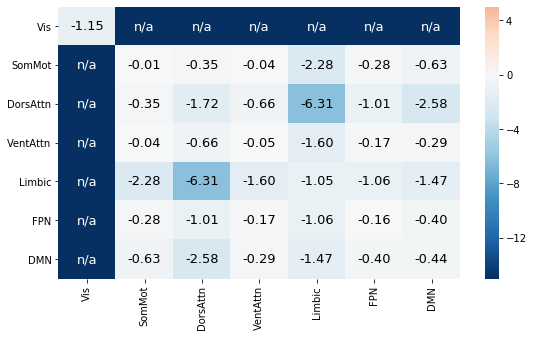

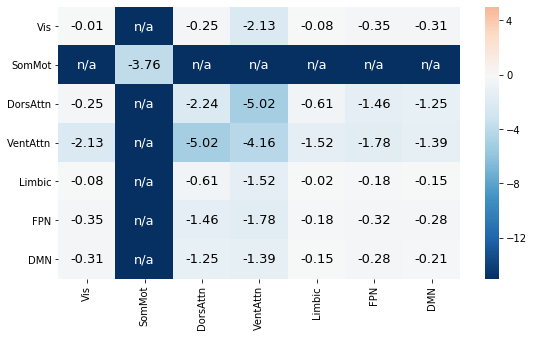

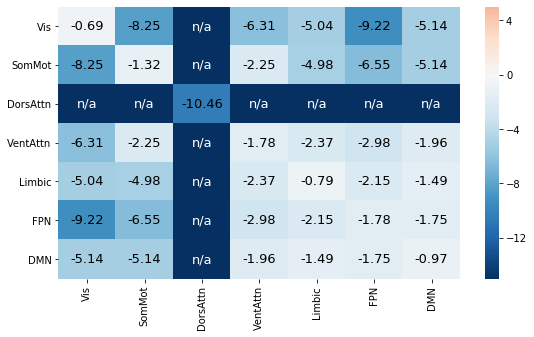

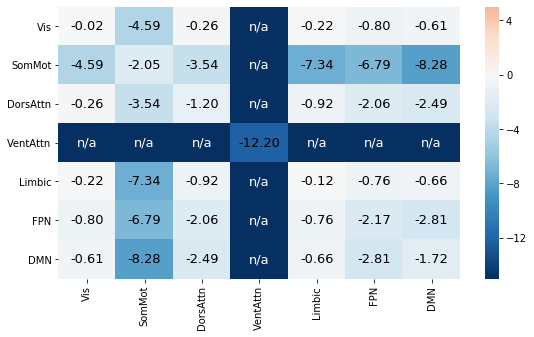

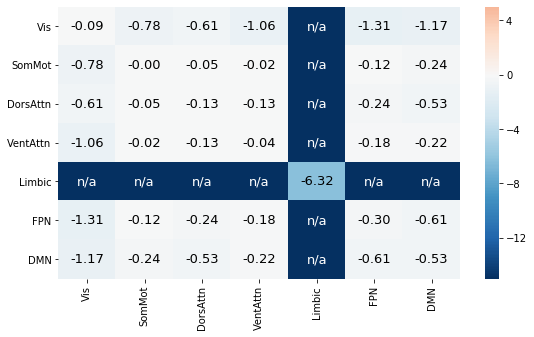

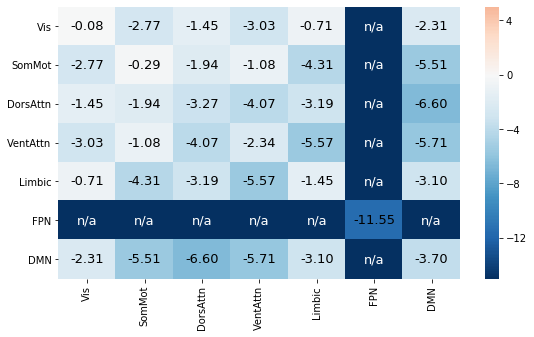

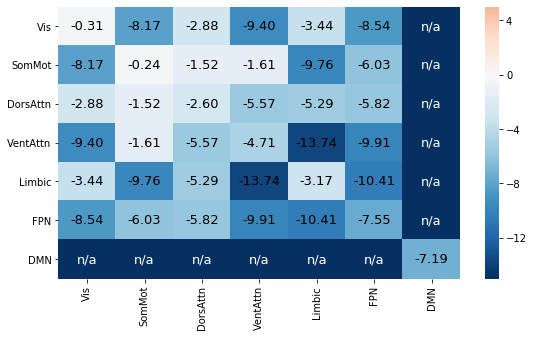

In [645]:
for i in range(7):
    fig, ax = plt.subplots(figsize=(9,5))
    sns.heatmap(percent_change_all_ntwx_all_vals[i,:,:],cmap='RdBu_r',center=0, vmin=-15, vmax = 5)
    # Annotate each cell with the corresponding value
    for x in range(len(Ntwx_labels)):
        for y in range(len(Ntwx_labels)):
            value = percent_change_all_ntwx_all_vals[i, x, y]
            if value > -100:
                ax.text(y + 0.5, x + 0.5, f'{value:.2f}', ha='center', va='center', color='black', fontsize=13)
            elif value == -100:
                ax.text(y + 0.5, x + 0.5, 'n/a', ha='center', va='center', color='white', fontsize=13)
    ax.set_xticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_xticklabels(Ntwx_labels, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_yticklabels(Ntwx_labels, rotation=0, ha='right')
    plt.show()


### vis plots

In [671]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],vis_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [672]:
for i in range(7):
    if i!=0:
        del percent_change_all_ntwx[i][0] 

In [673]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

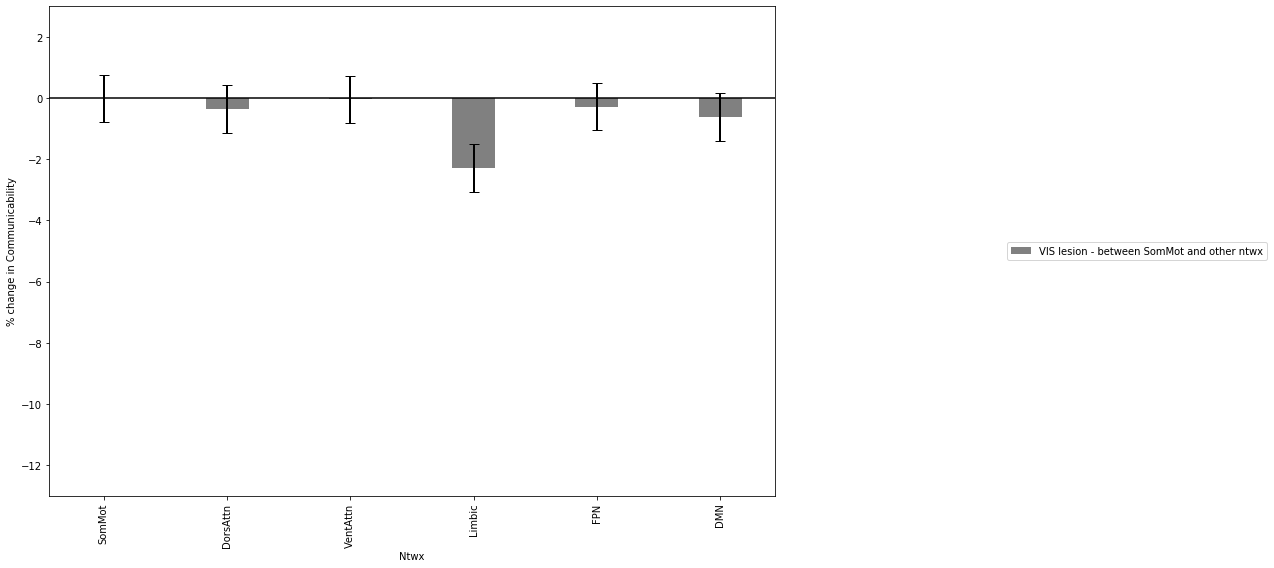

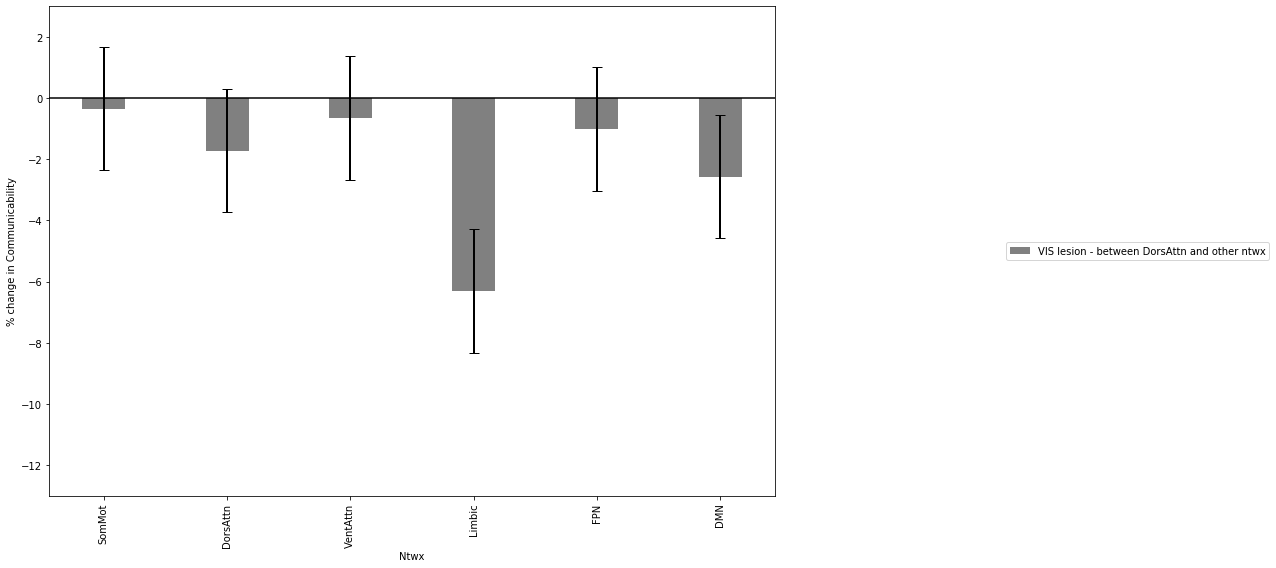

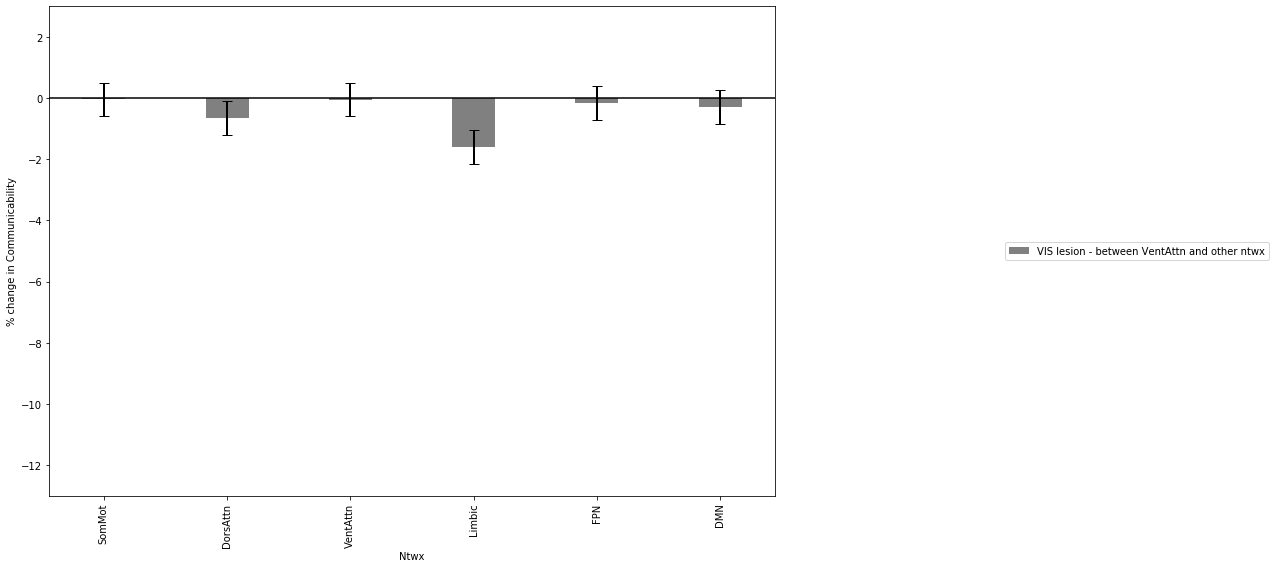

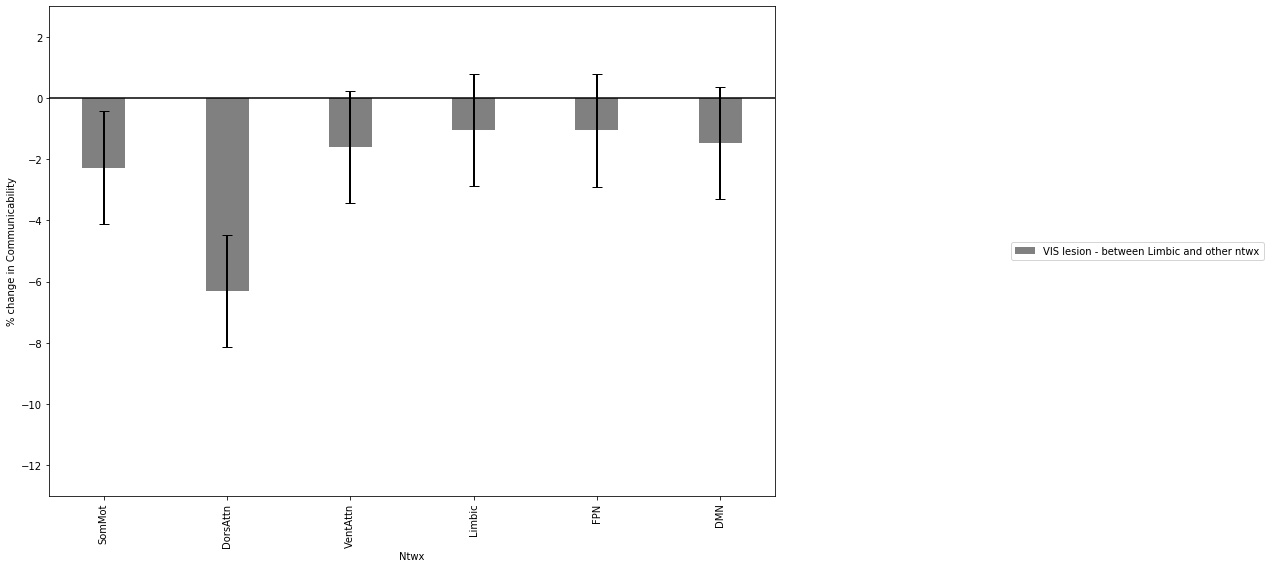

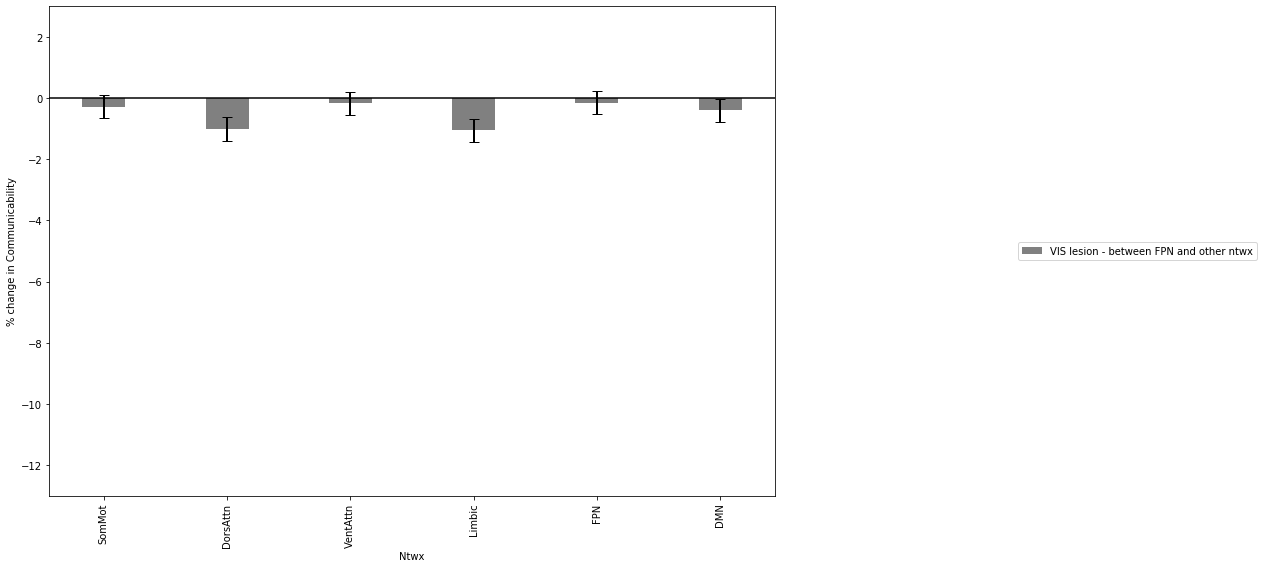

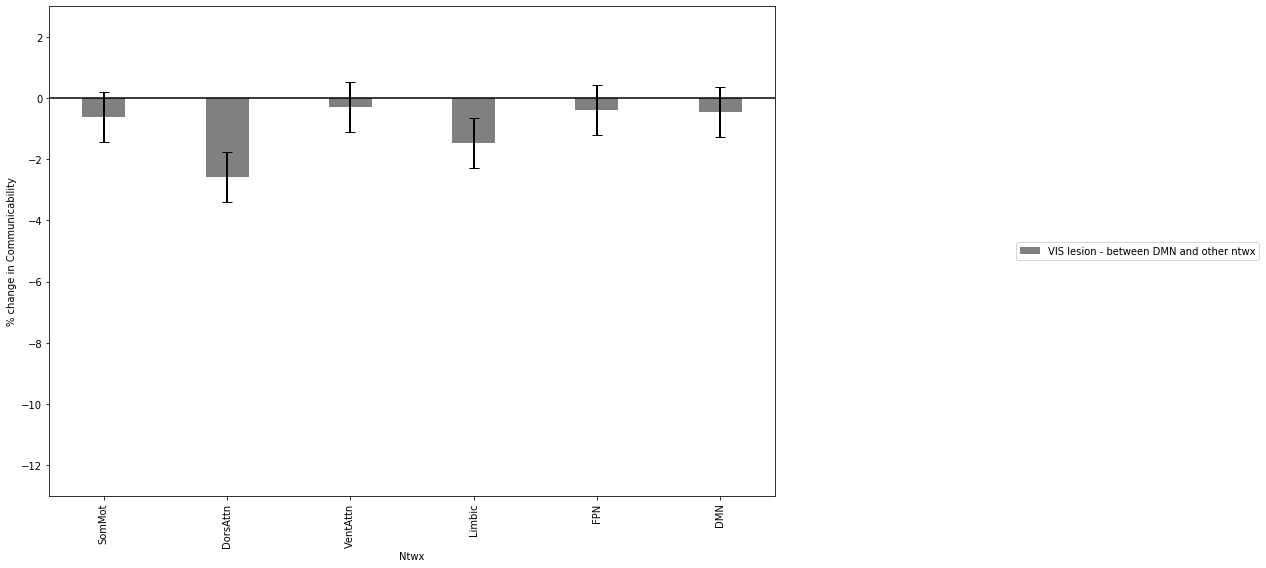

In [674]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=0:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='VIS lesion - between {0} and other ntwx'.format(Ntwx_labels[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels)
        plt.ylim([-13,3])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### smt plots

In [680]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],smt_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [681]:
for i in range(7):
    if i!=1:
        del percent_change_all_ntwx[i][1] 

In [682]:
Ntwx_labels = ['SomMot', 'Vis', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [684]:
Ntwx_labels2 = ['Vis', 'SomMot','DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

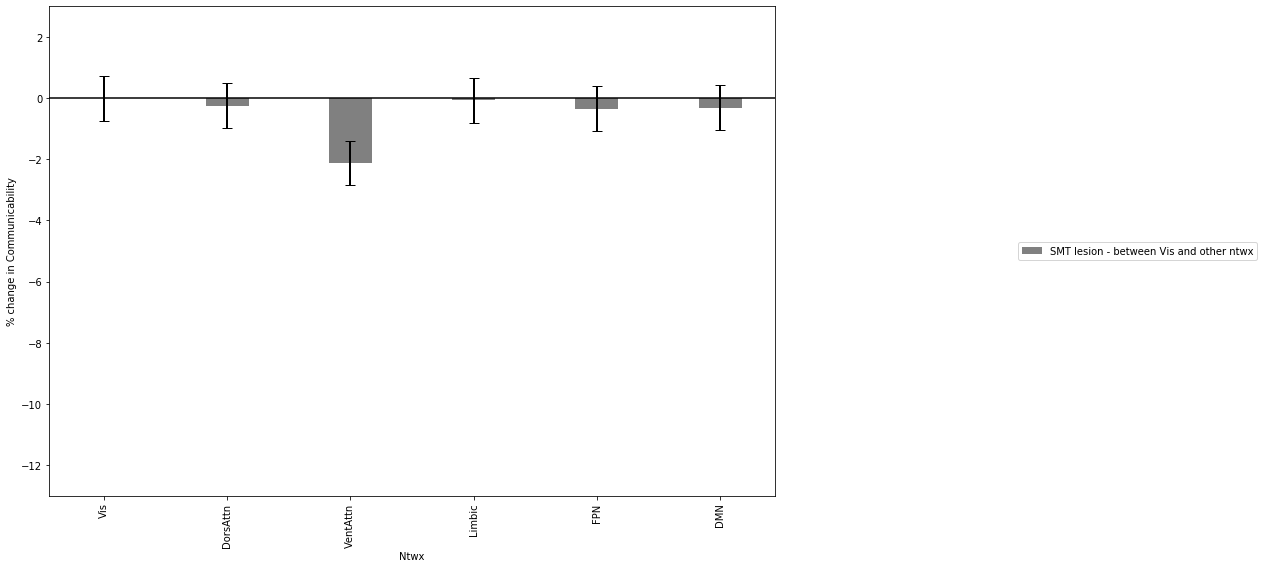

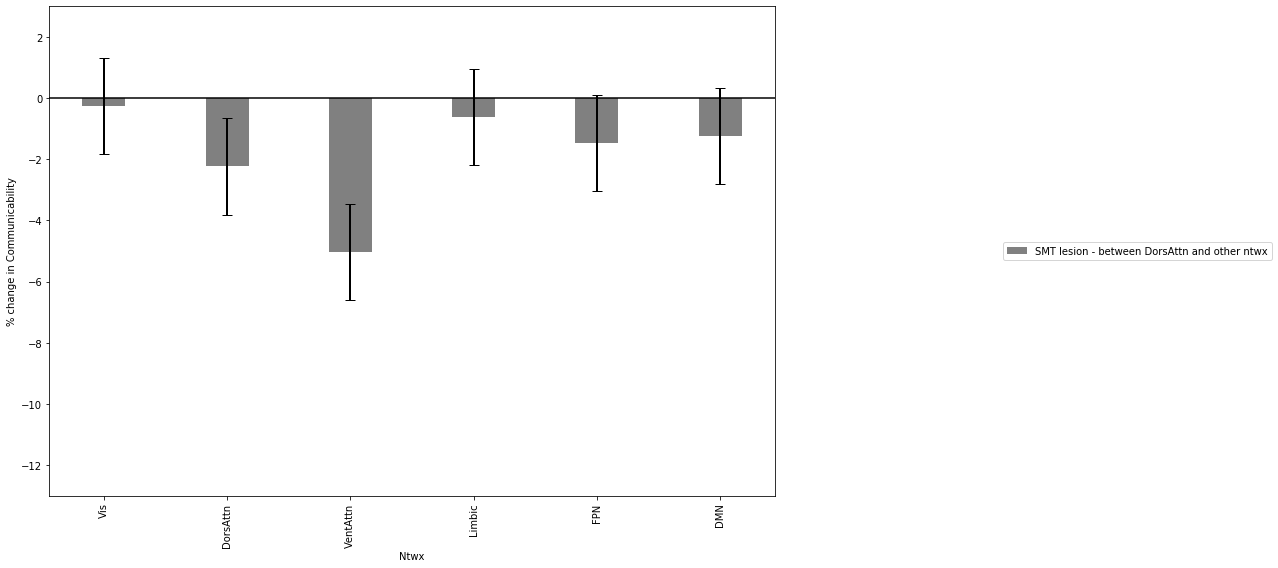

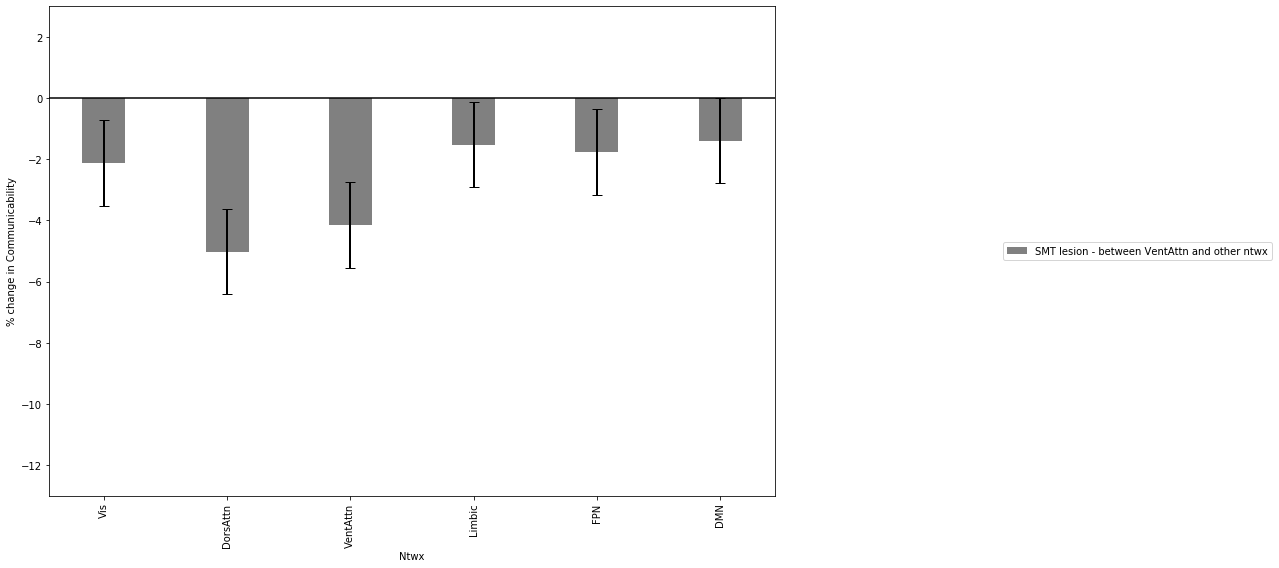

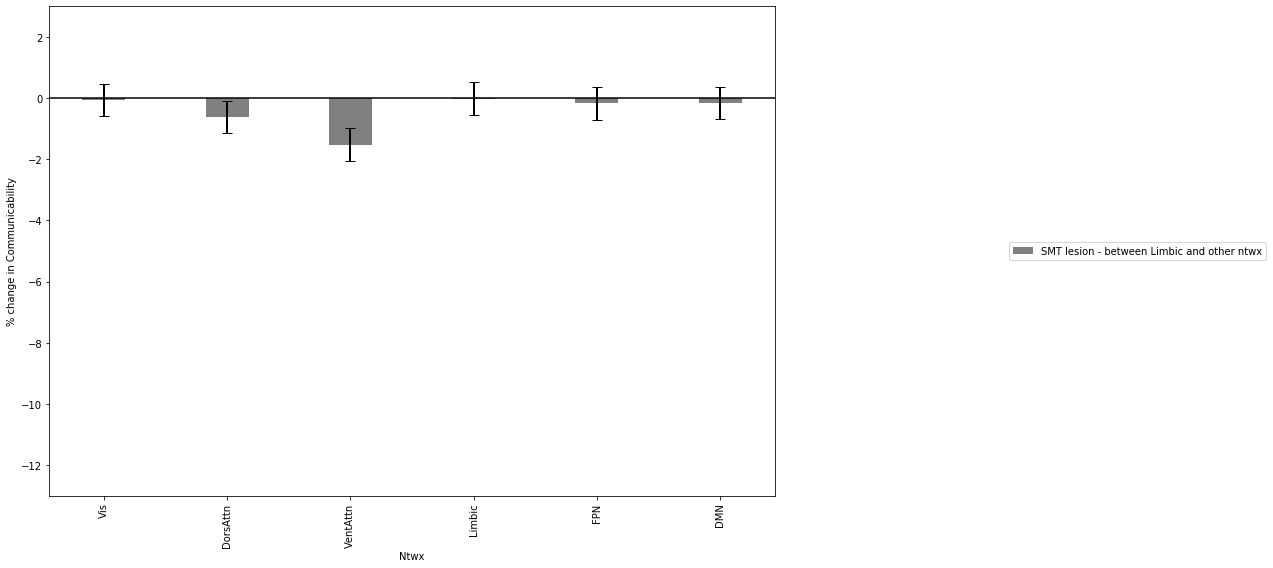

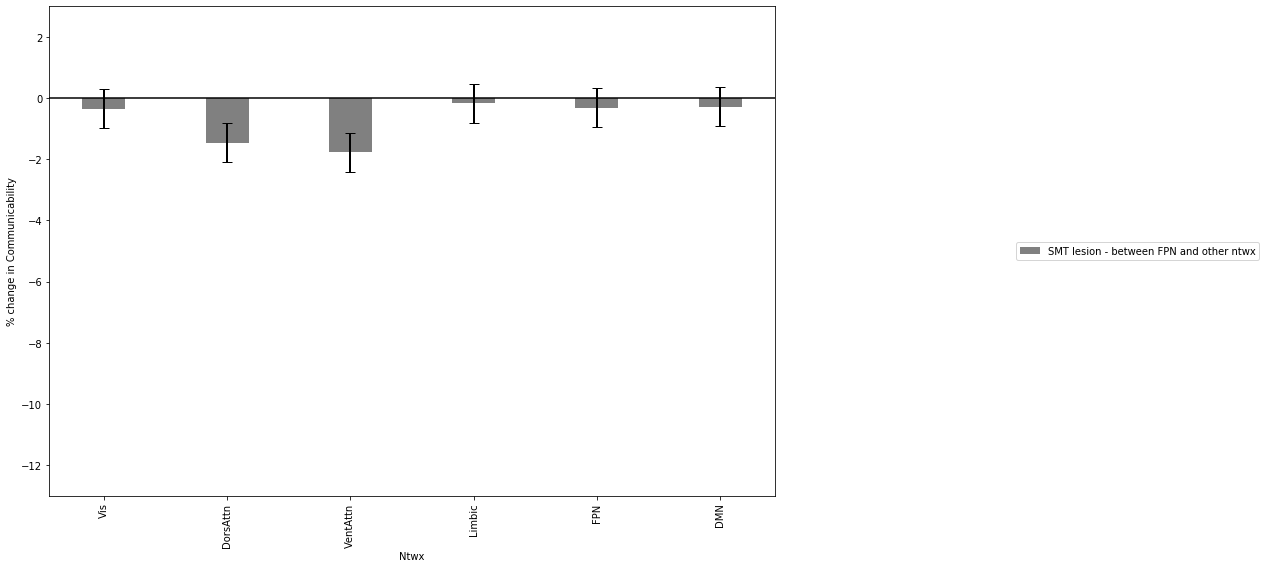

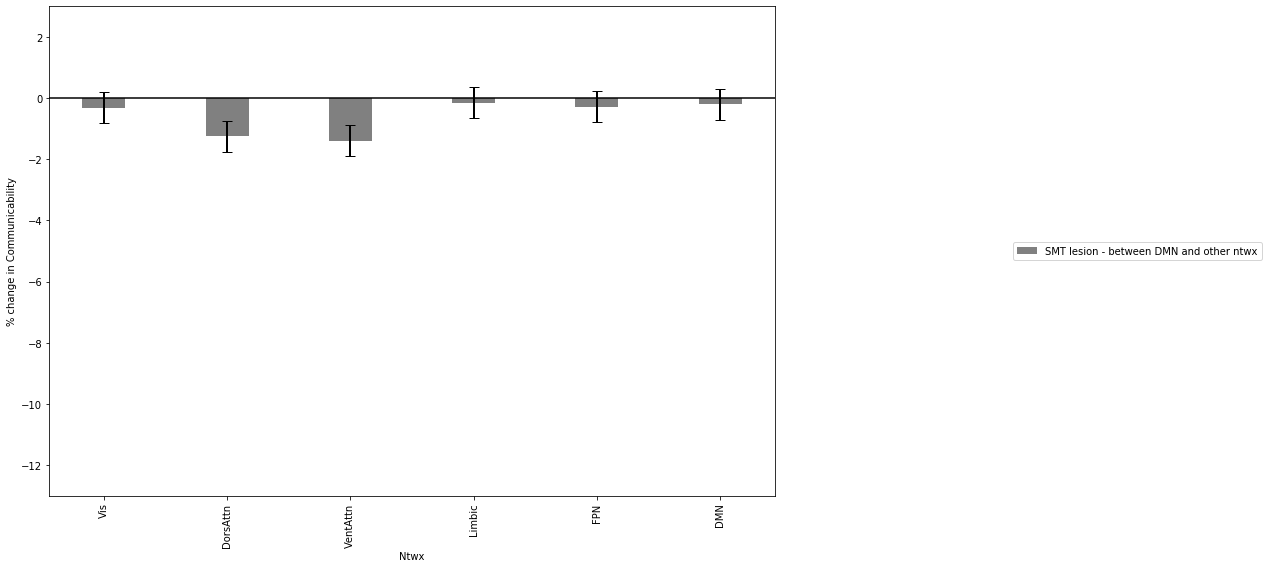

In [685]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=1:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='SMT lesion - between {0} and other ntwx'.format(Ntwx_labels2[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels)
        plt.ylim([-13,3])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### dan plots

In [413]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],dan_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [414]:
for i in range(7):
    if i!=2:
        del percent_change_all_ntwx[i][2] 

In [415]:
Ntwx_labels2 = ['DorsAttn', 'Vis', 'SomMot', 'VentAttn', 'Limbic', 'FPN', 'DMN']

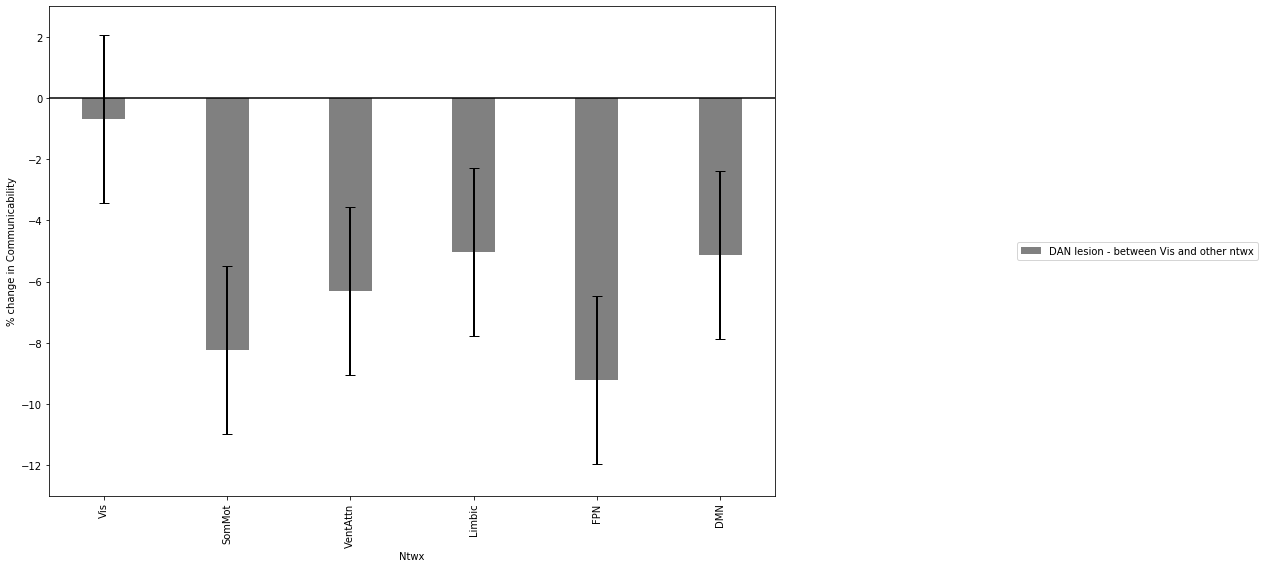

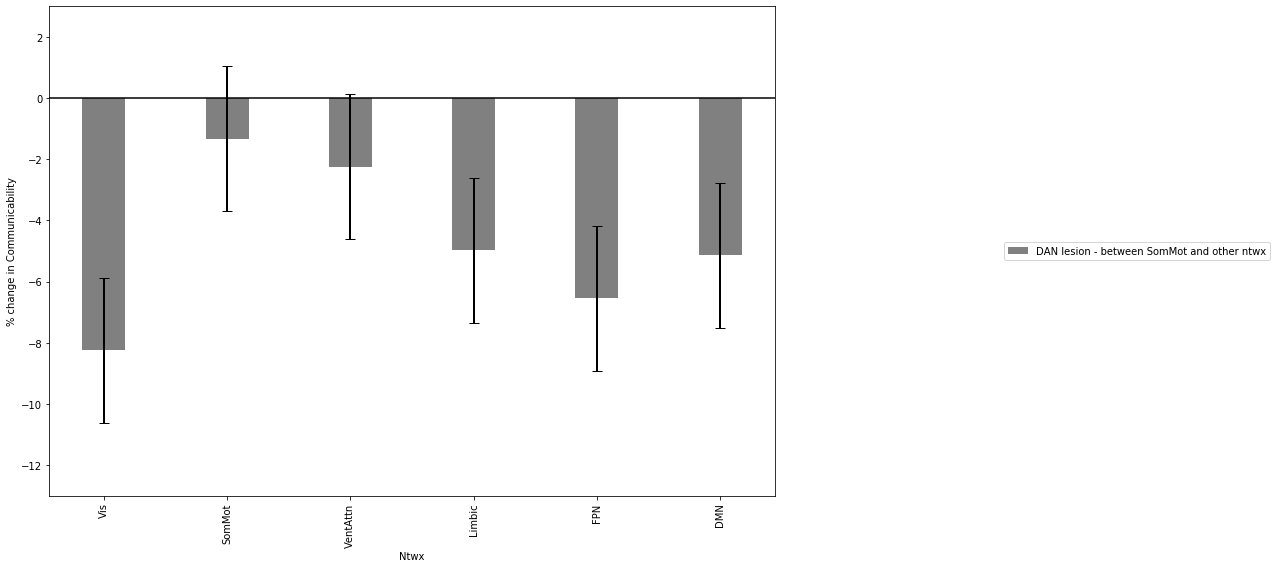

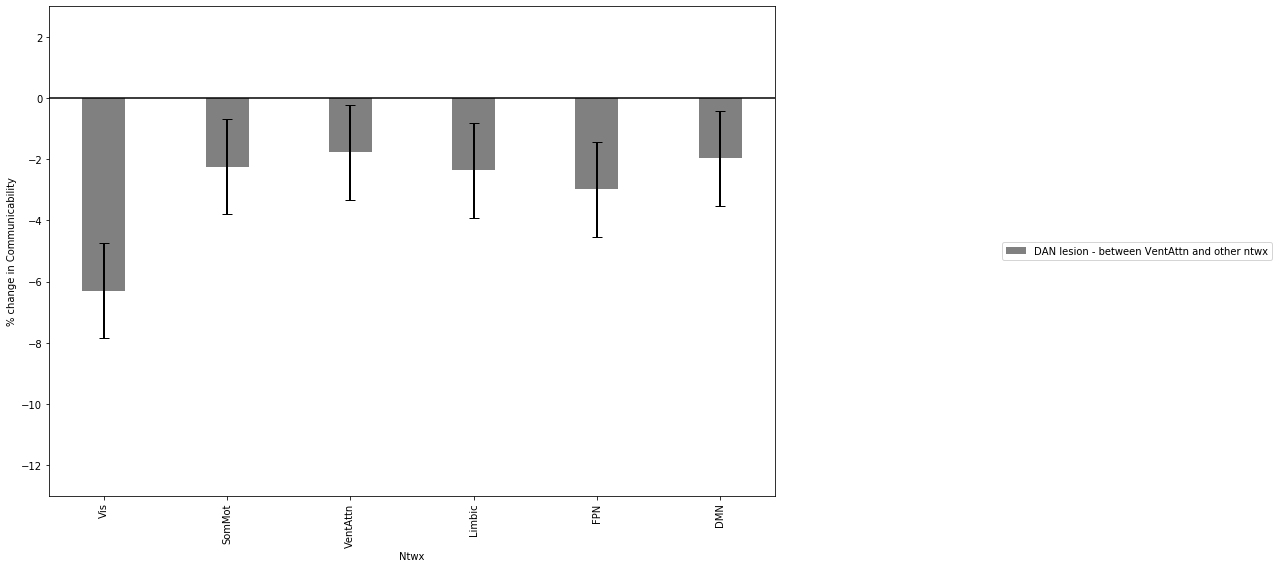

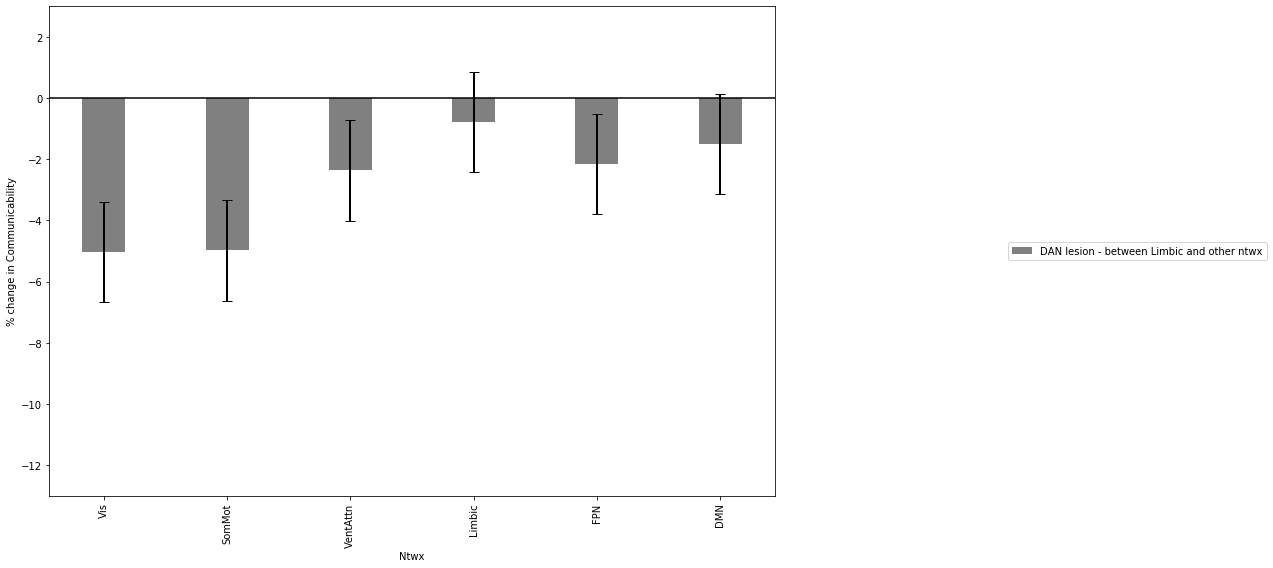

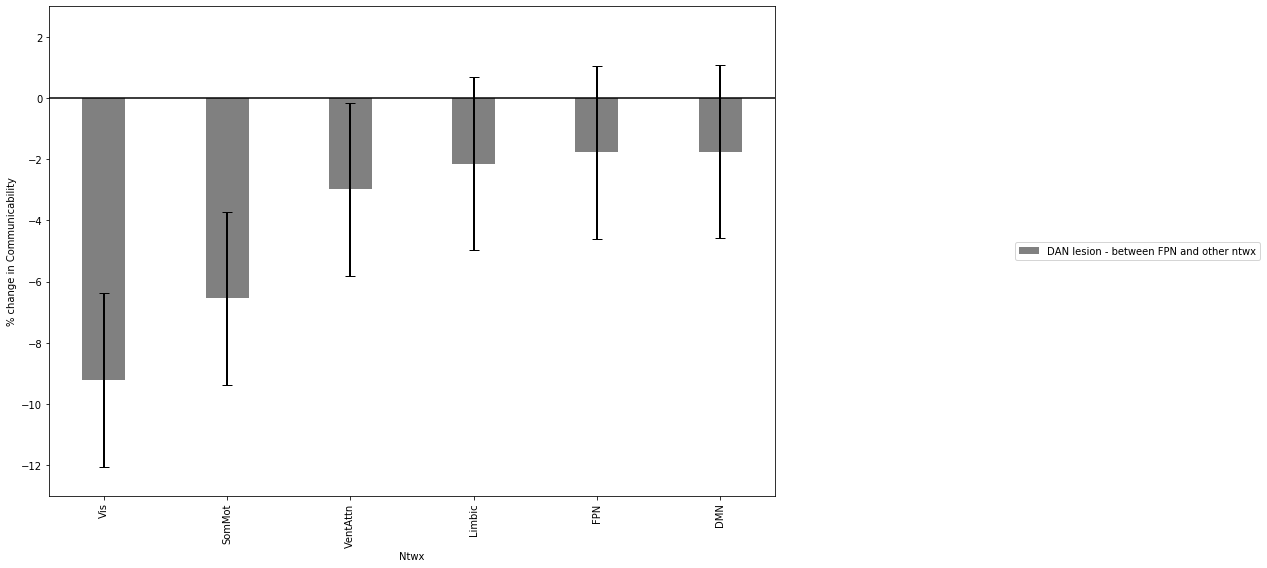

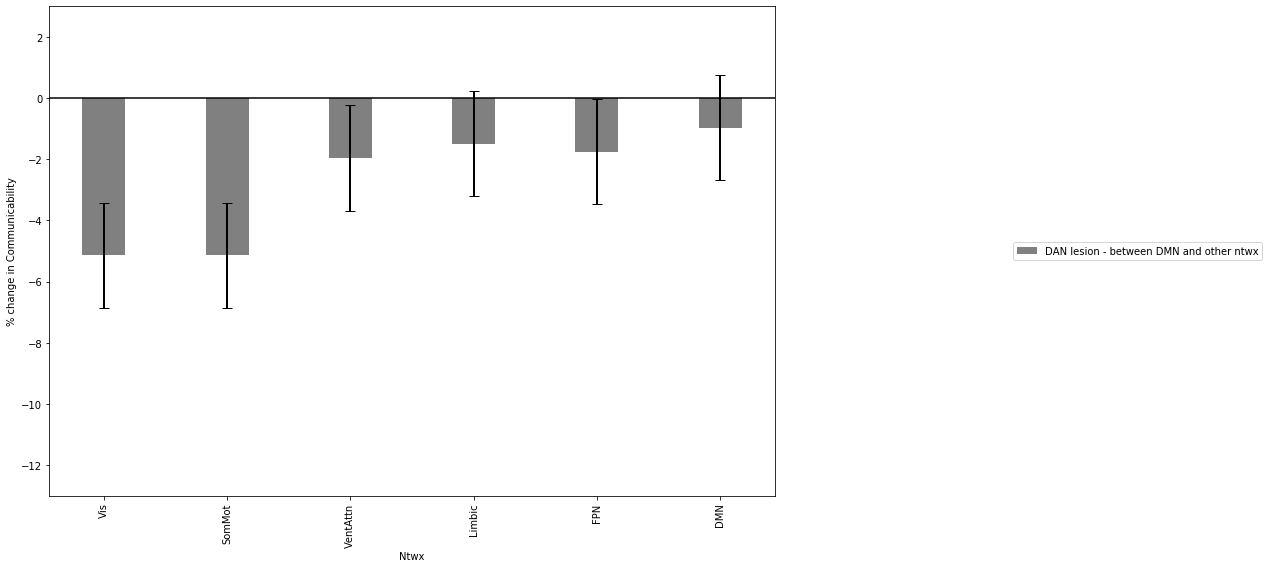

In [419]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=2:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='DAN lesion - between {0} and other ntwx'.format(Ntwx_labels[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels2)
        plt.ylim([-13,3])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### van plots

In [580]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],van_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [581]:
for i in range(7):
    if i!=3:
        del percent_change_all_ntwx[i][3] 

In [582]:
Ntwx_labels2 = ['VentAttn', 'Vis', 'SomMot', 'DorsAttn', 'Limbic', 'FPN', 'DMN']

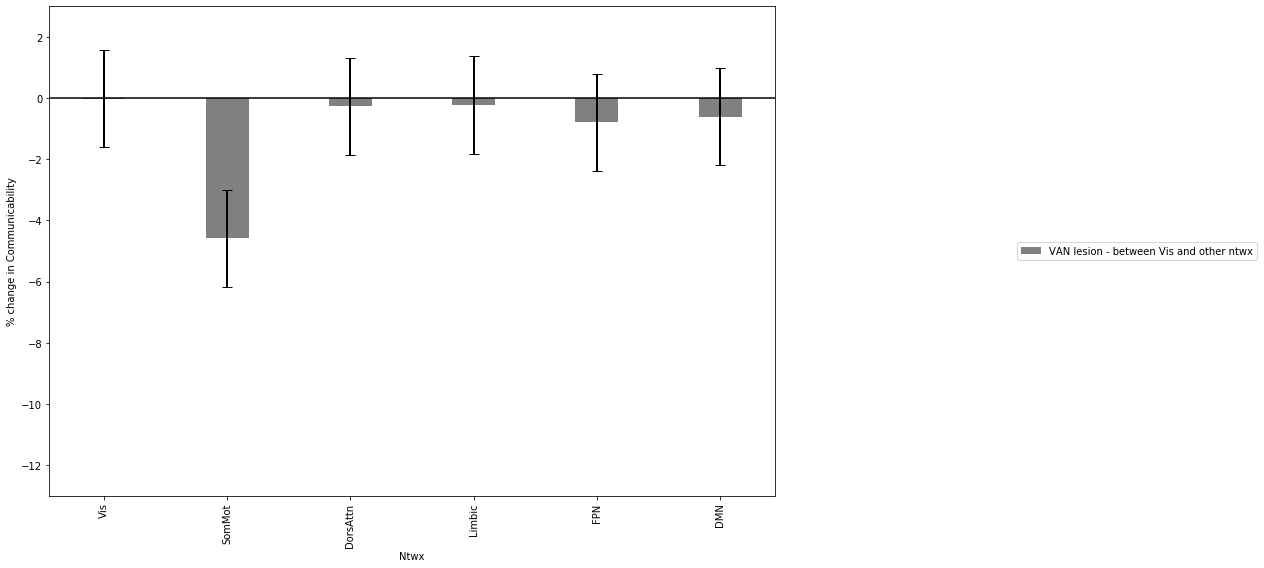

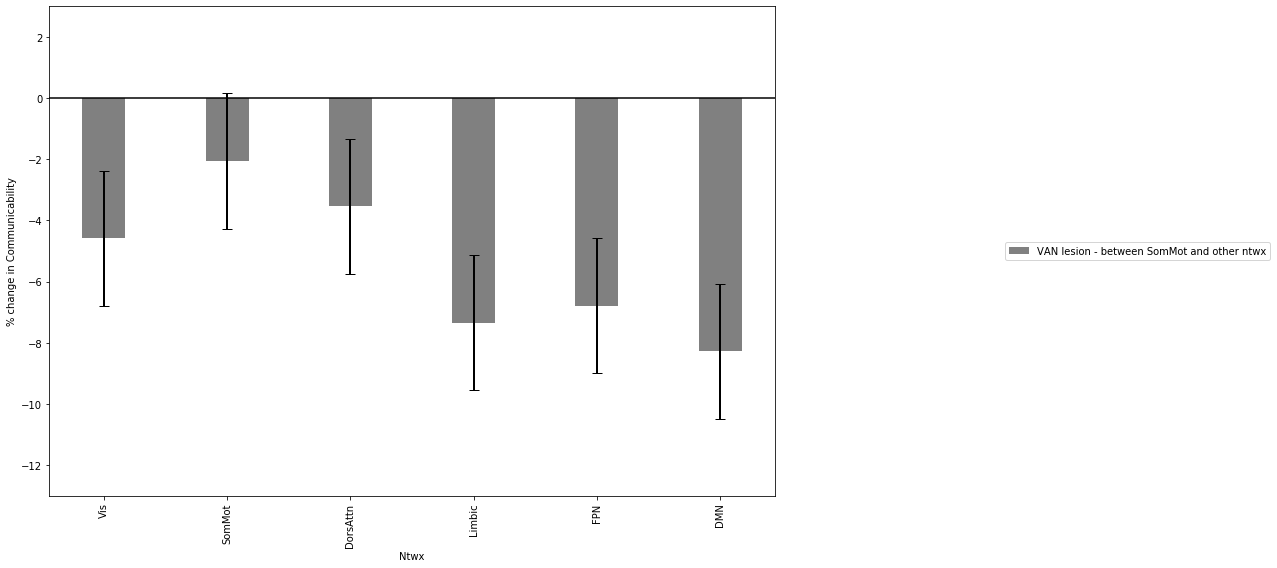

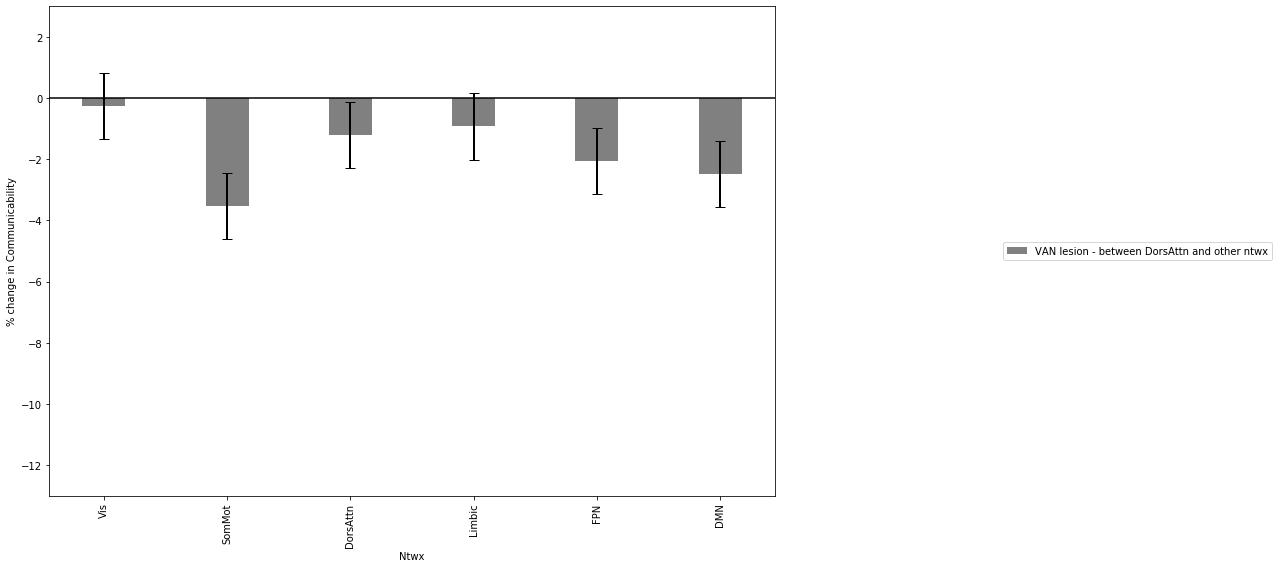

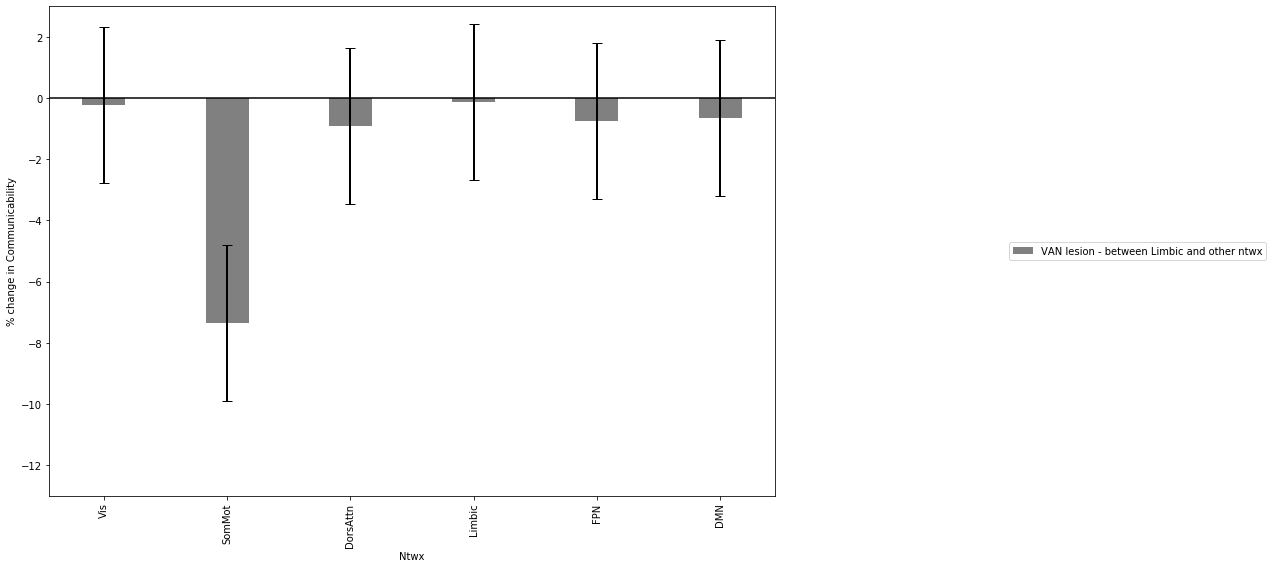

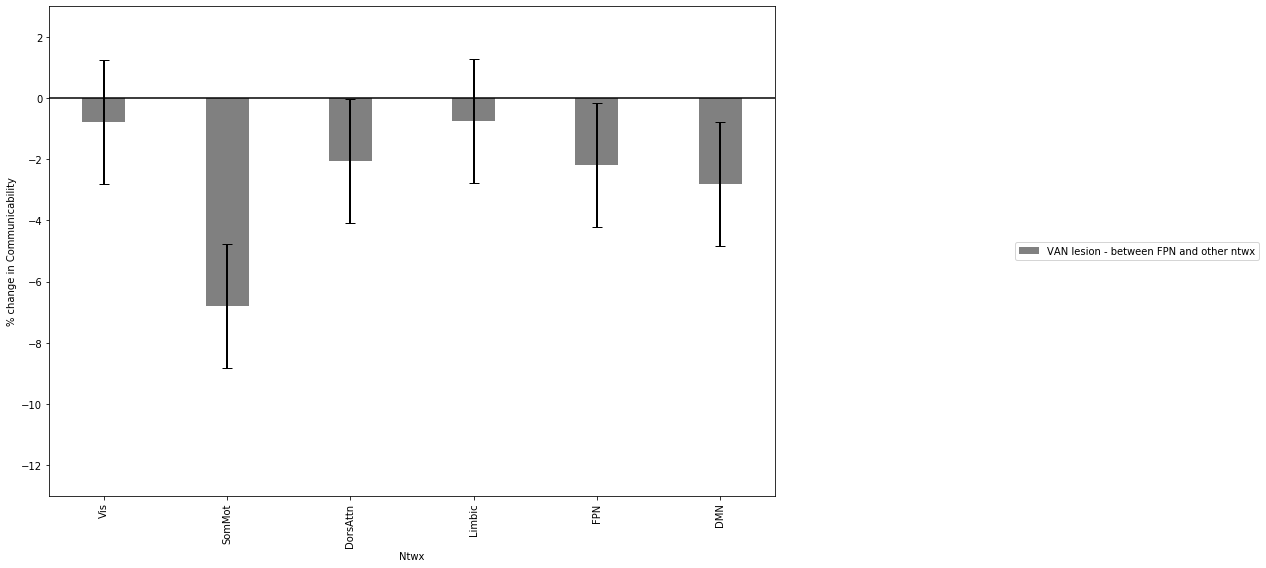

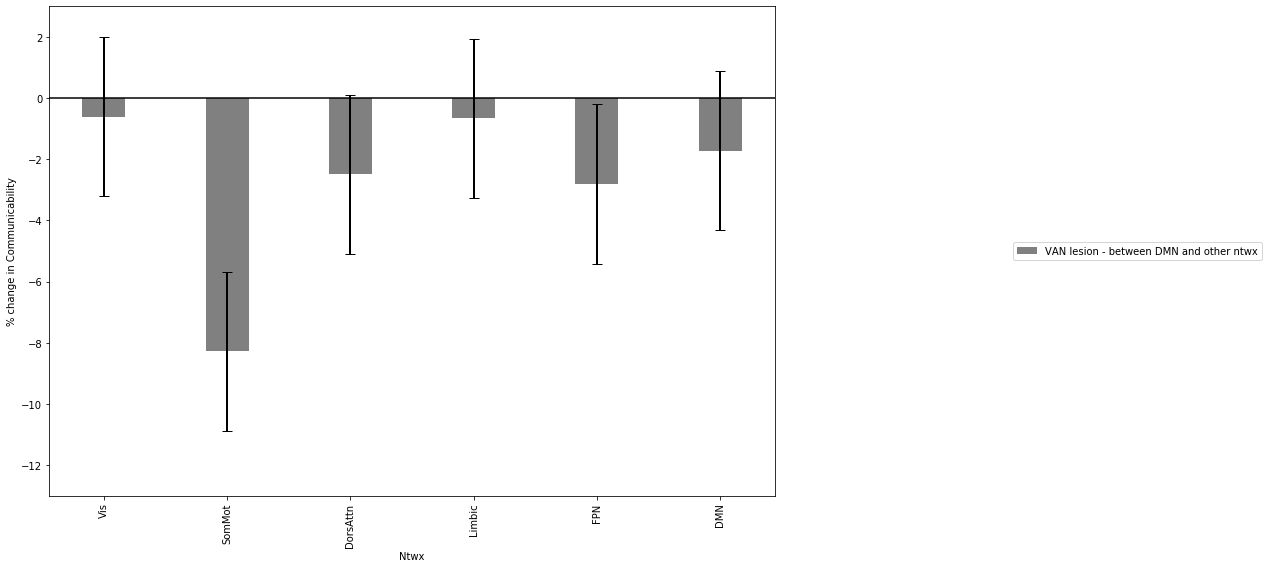

In [584]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=3:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='VAN lesion - between {0} and other ntwx'.format(Ntwx_labels[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels2)
        plt.ylim([-13,3])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### lim plots

In [532]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],lim_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [533]:
for i in range(7):
    if i!=4:
        del percent_change_all_ntwx[i][4] 

In [534]:
Ntwx_labels2 = ['Limbic', 'Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'FPN', 'DMN']

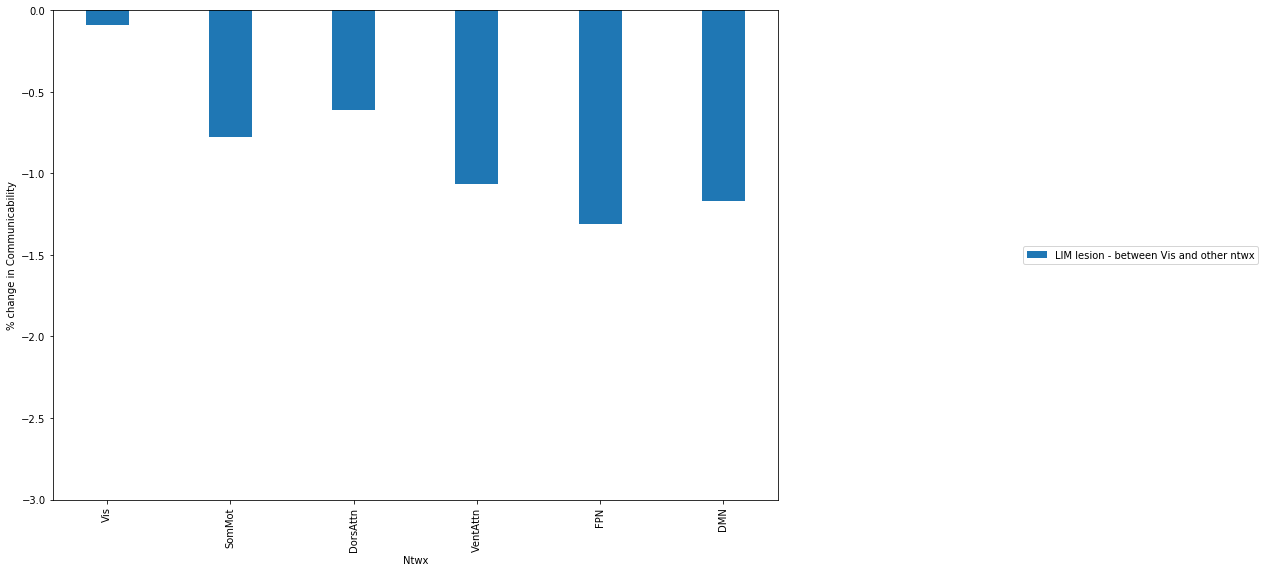

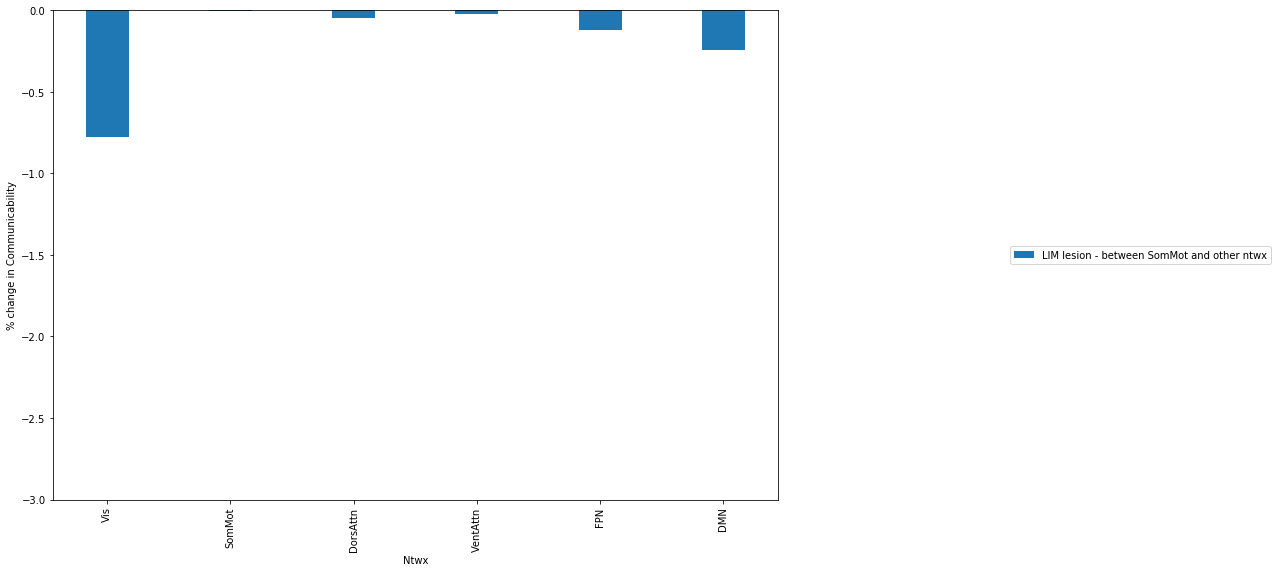

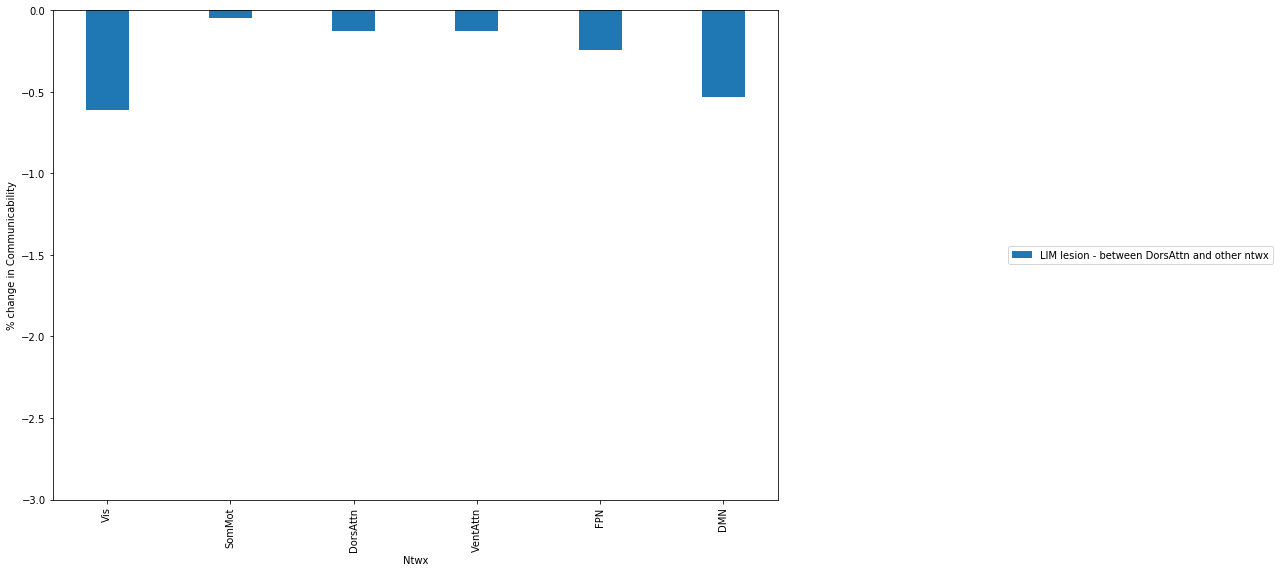

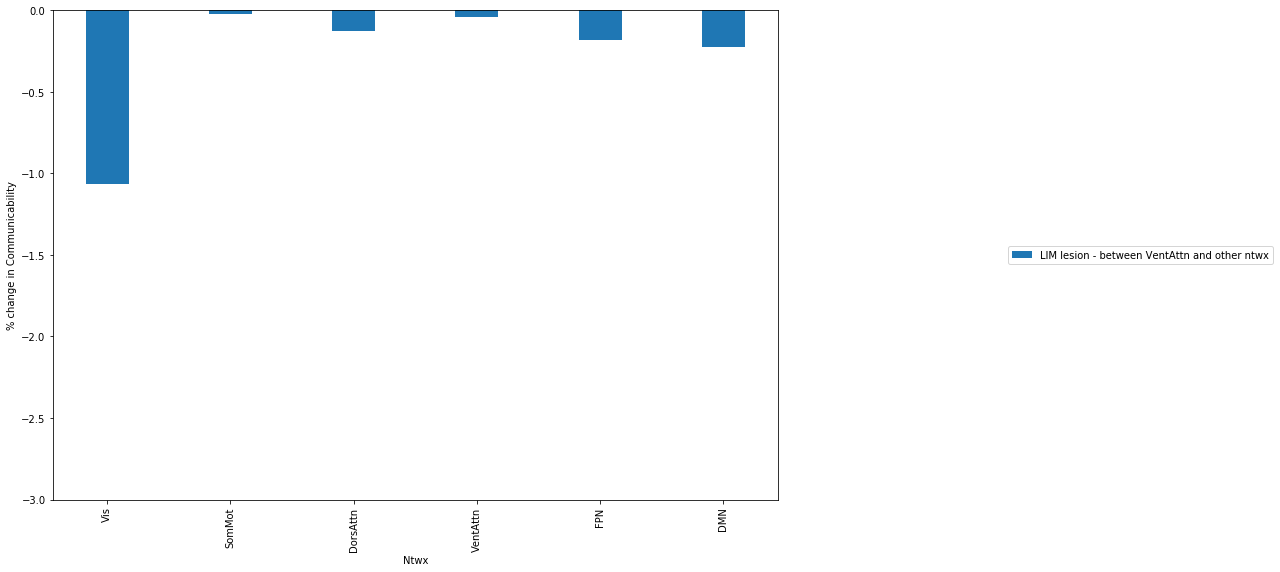

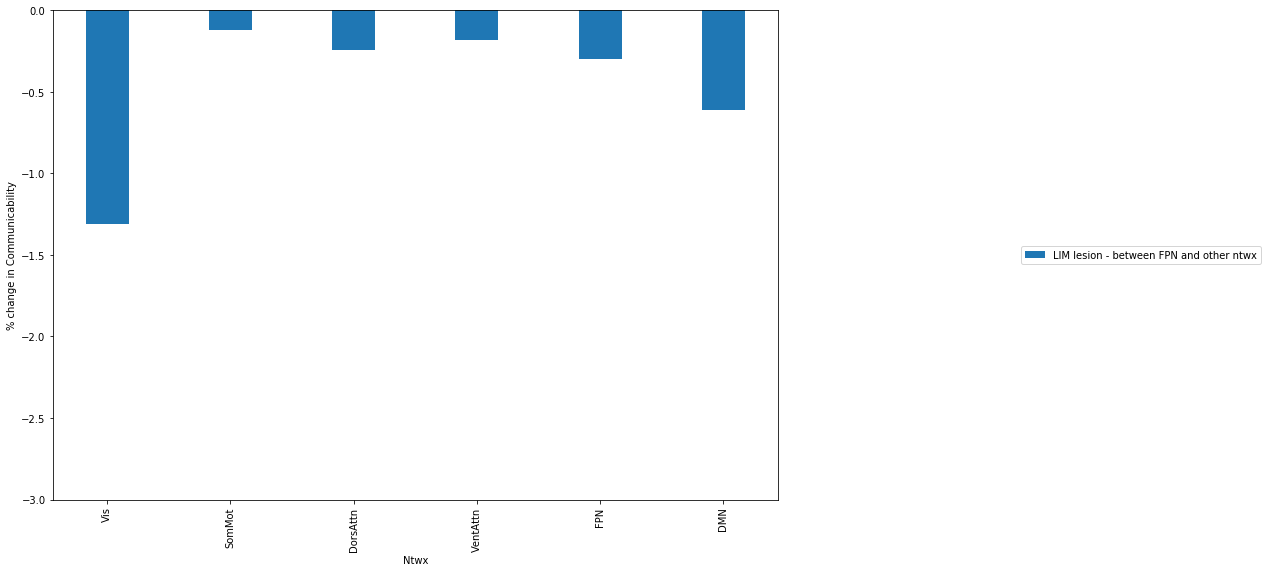

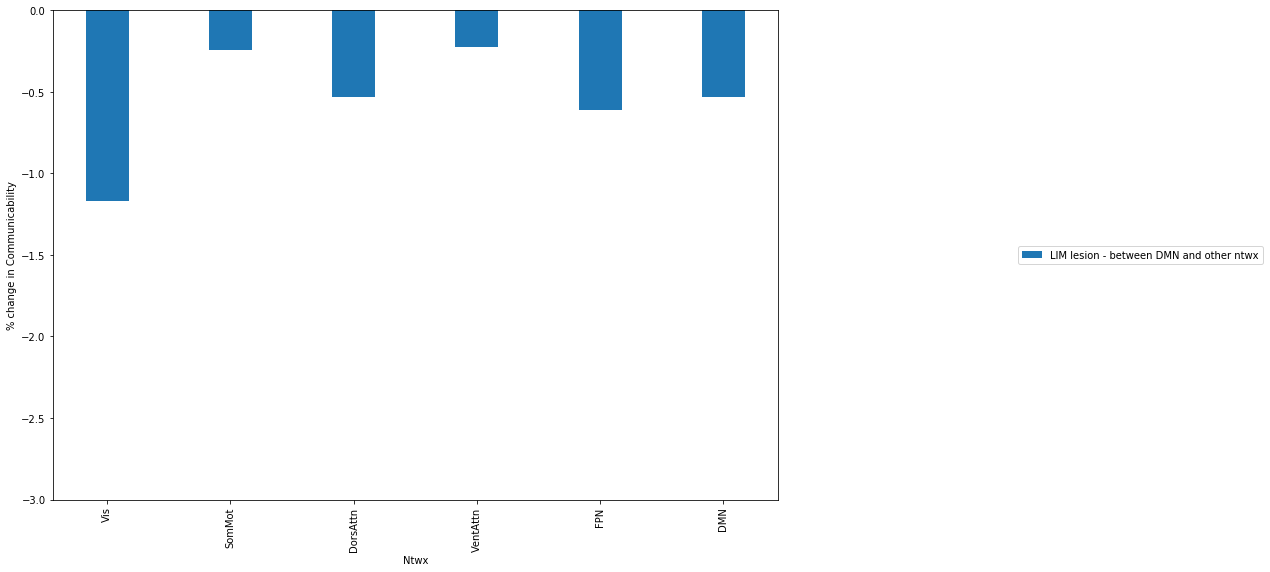

In [535]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=4:
        fig, ax = plt.subplots(figsize=(13,9))
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='LIM lesion - between {0} and other ntwx'.format(Ntwx_labels[i]))#,color=hex_codes[1:])
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels2)
        plt.ylim([-3,0])
        plt.xticks(rotation=90)
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### fpn plots

In [568]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],fpn_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [569]:
for i in range(7):
    if i!=5:
        del percent_change_all_ntwx[i][5] 

In [570]:
Ntwx_labels3 = ['FPN', 'Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'DMN']
Ntwx_labels33 = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

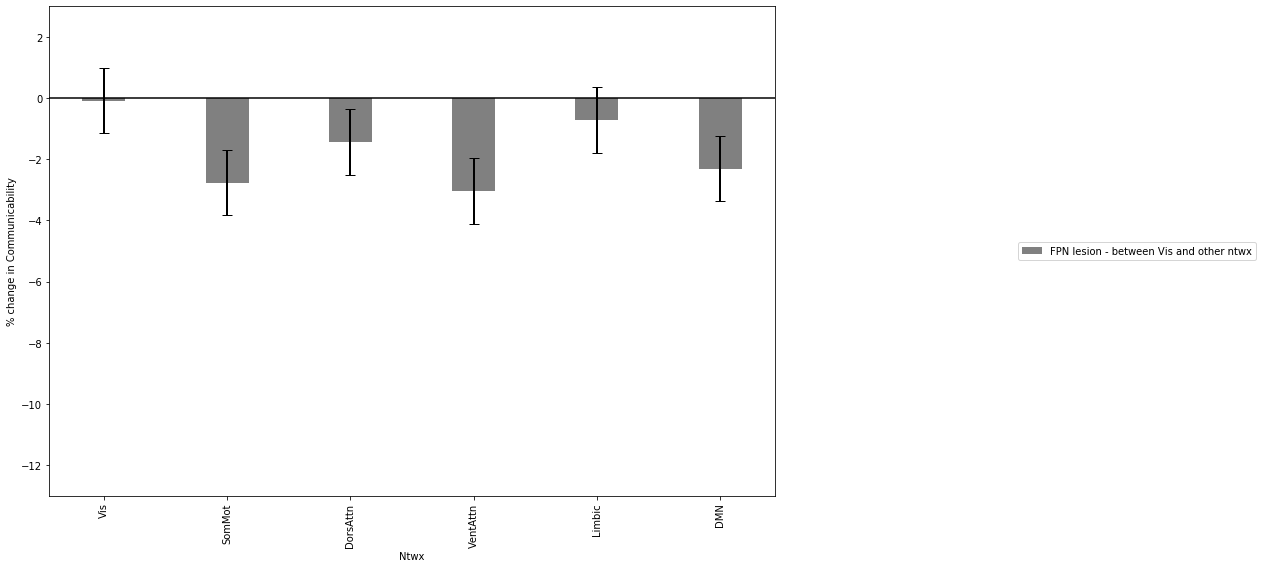

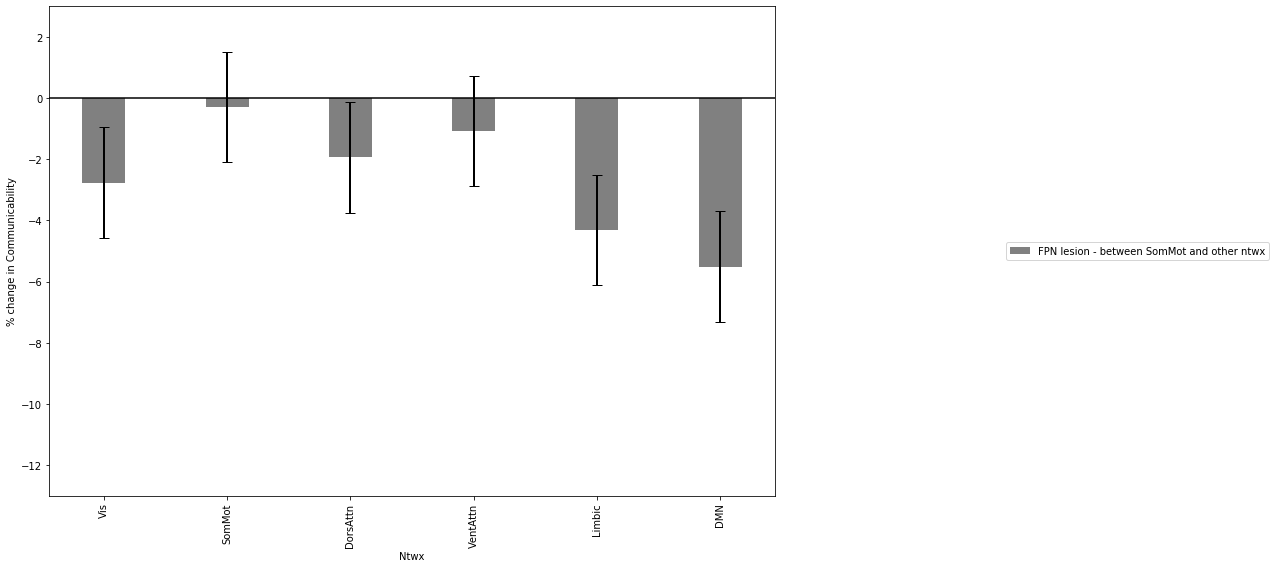

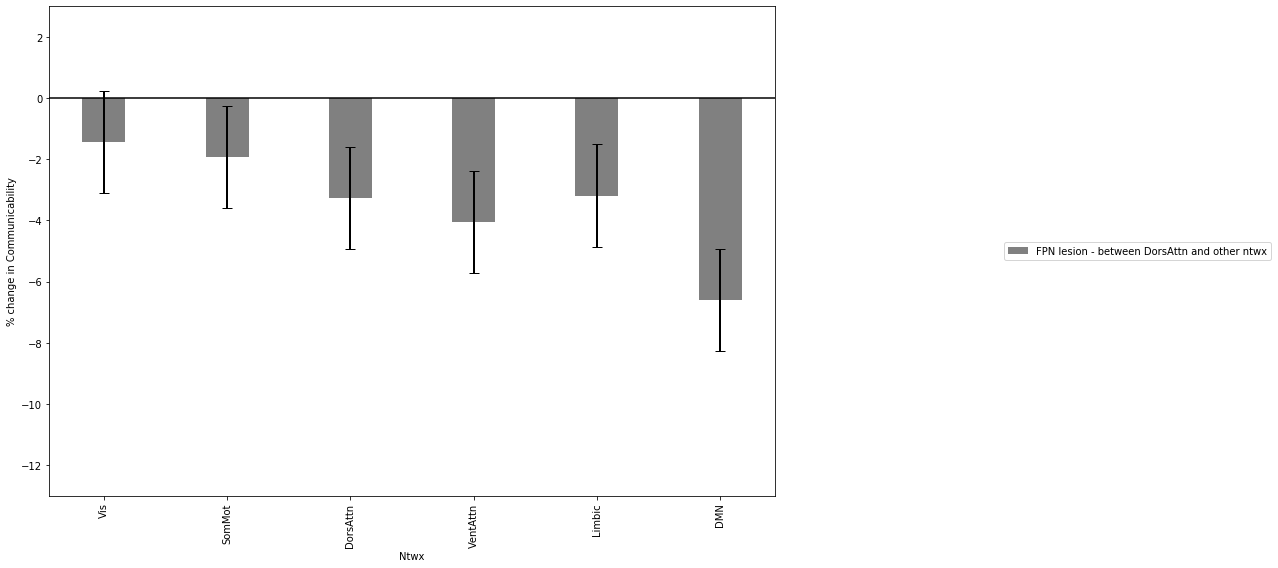

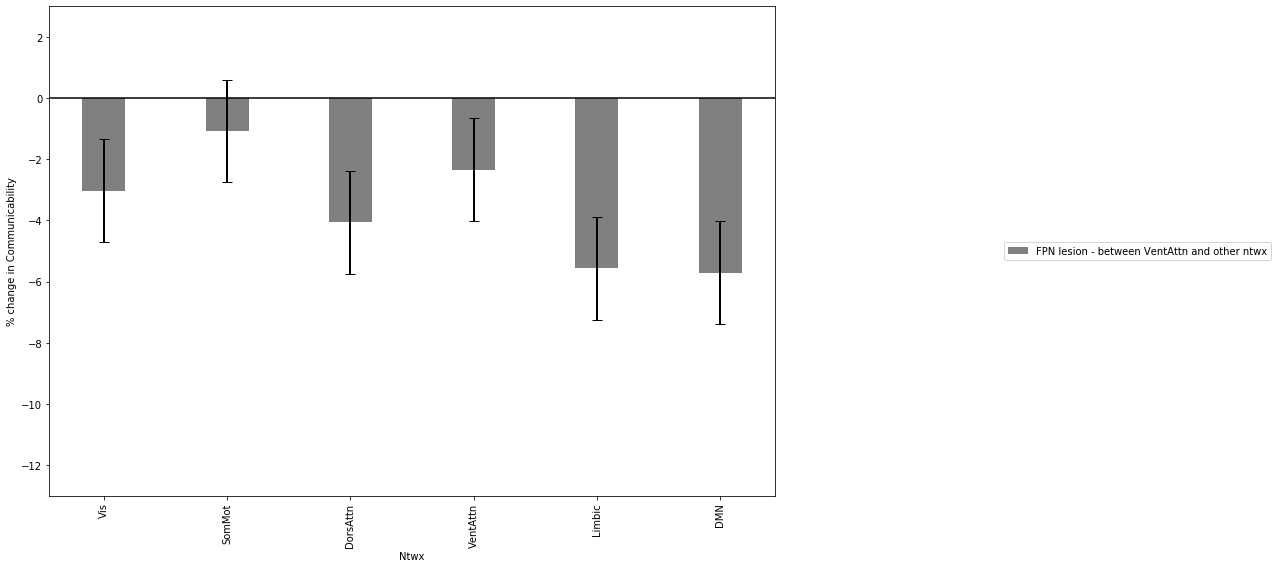

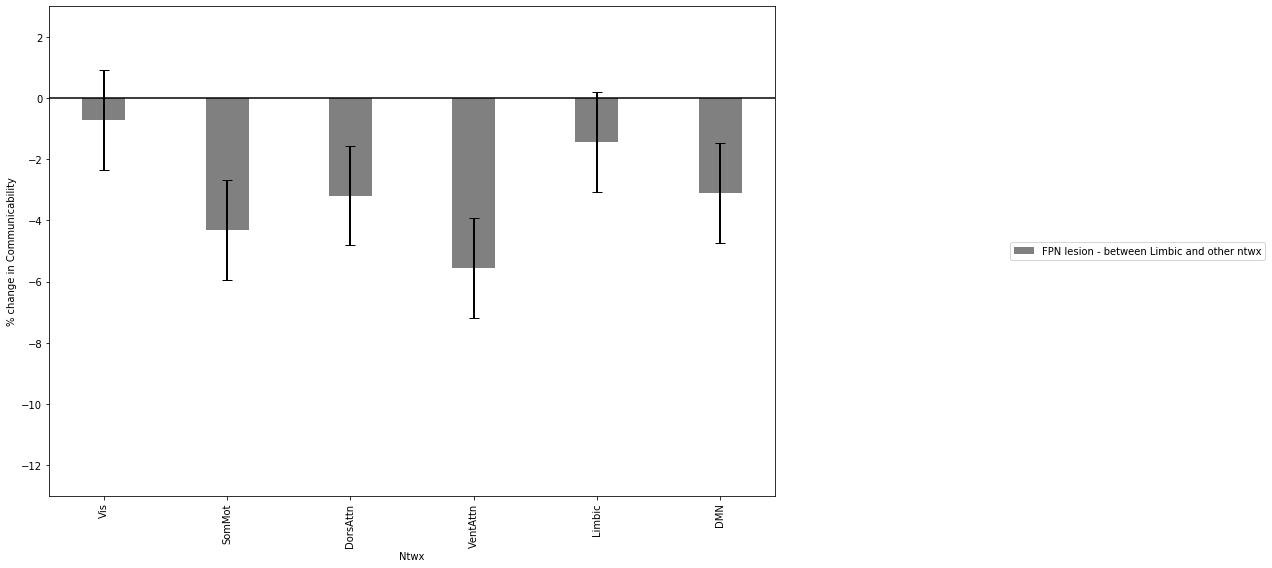

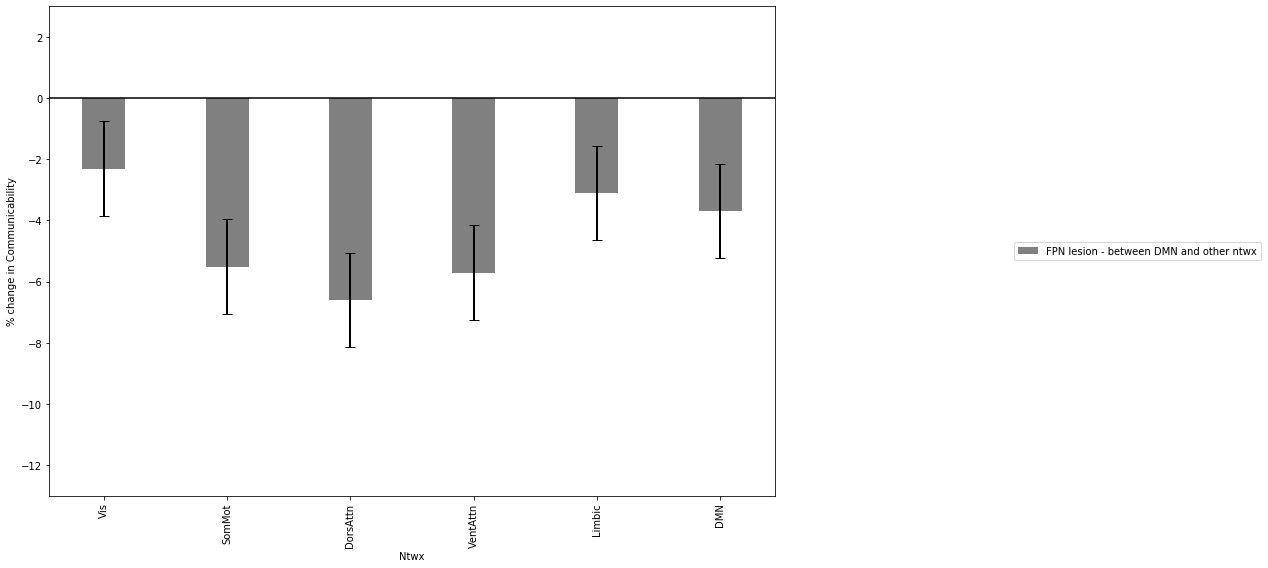

In [571]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=5:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='FPN lesion - between {0} and other ntwx'.format(Ntwx_labels33[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels3)
        plt.ylim([-13,3])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

### dmn plots

In [561]:
percent_change_all_ntwx = []
for i in range(7):
    percent_change = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],dmn_lesion_between_other_ntwx[i])]
    percent_change_all_ntwx.append(percent_change)
#     print(percent_change)
#     print('-----------------------------------')

In [562]:
for i in range(7):
    if i!=6:
        del percent_change_all_ntwx[i][6] 

In [563]:
Ntwx_labels2 = ['DMN', 'Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'LImbic', 'FPN']

Ntwx_labels22 = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'LImbic', 'FPN', 'DMN']

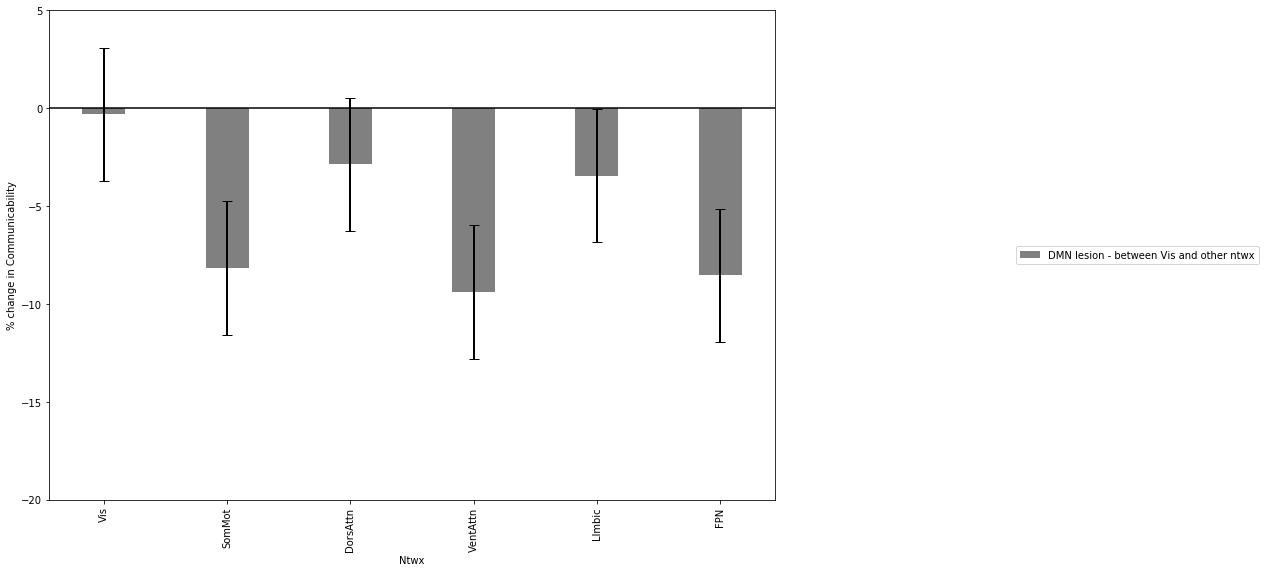

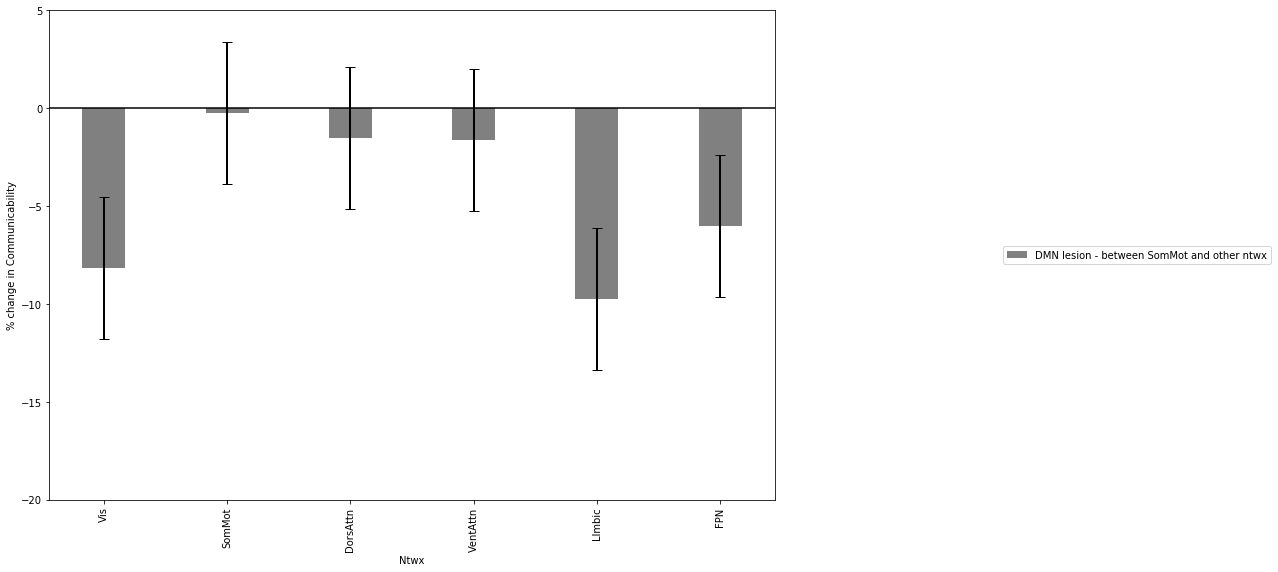

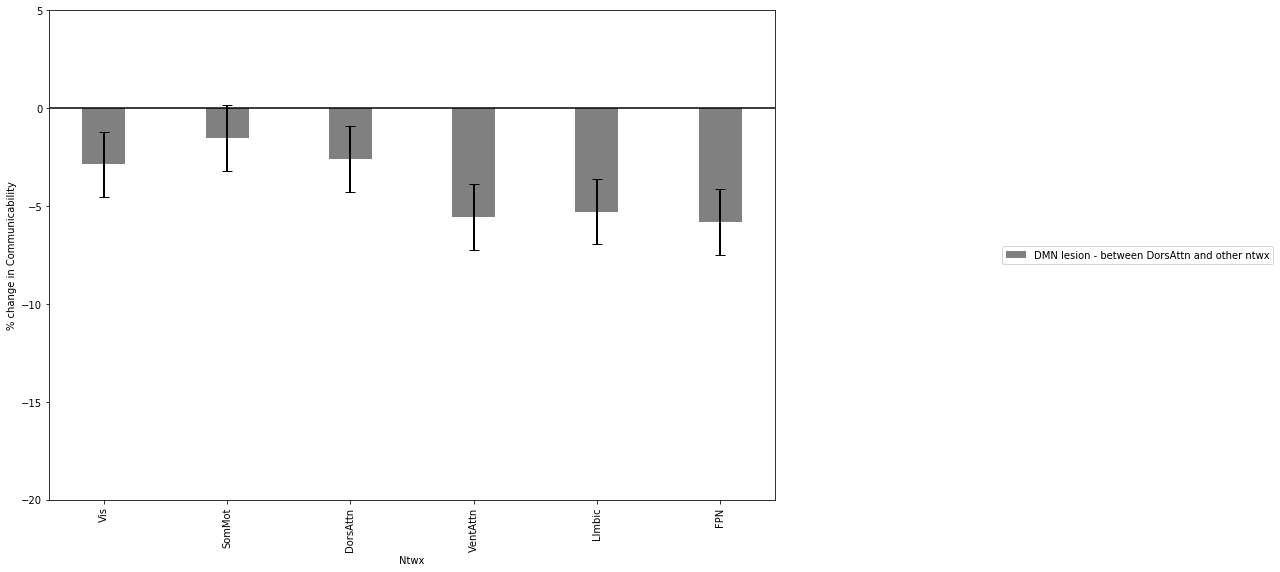

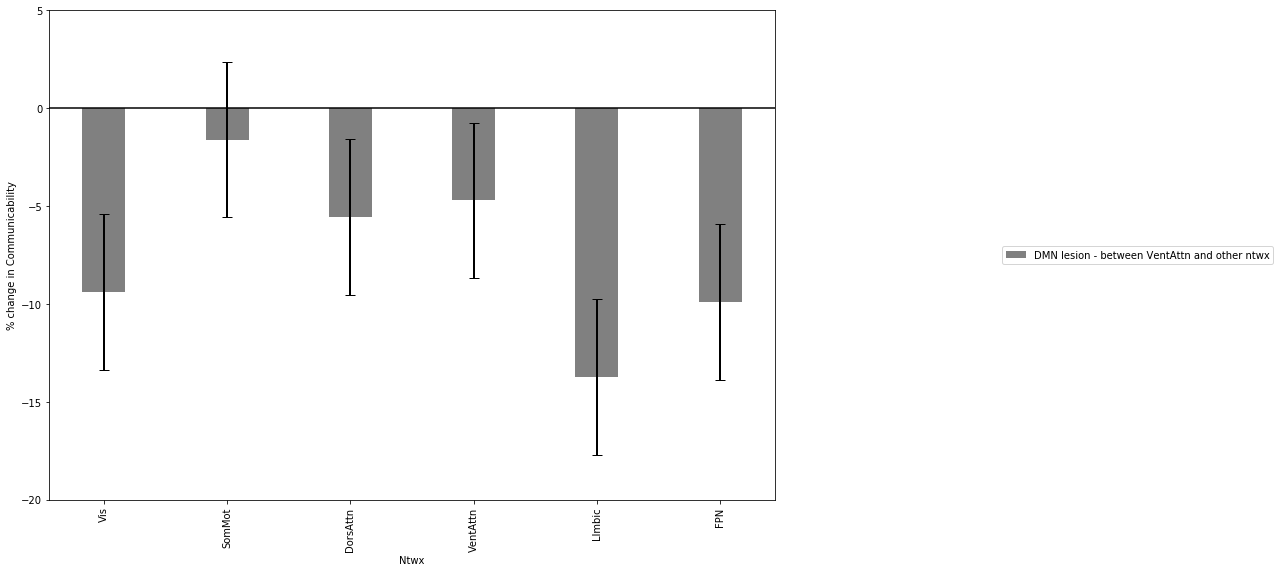

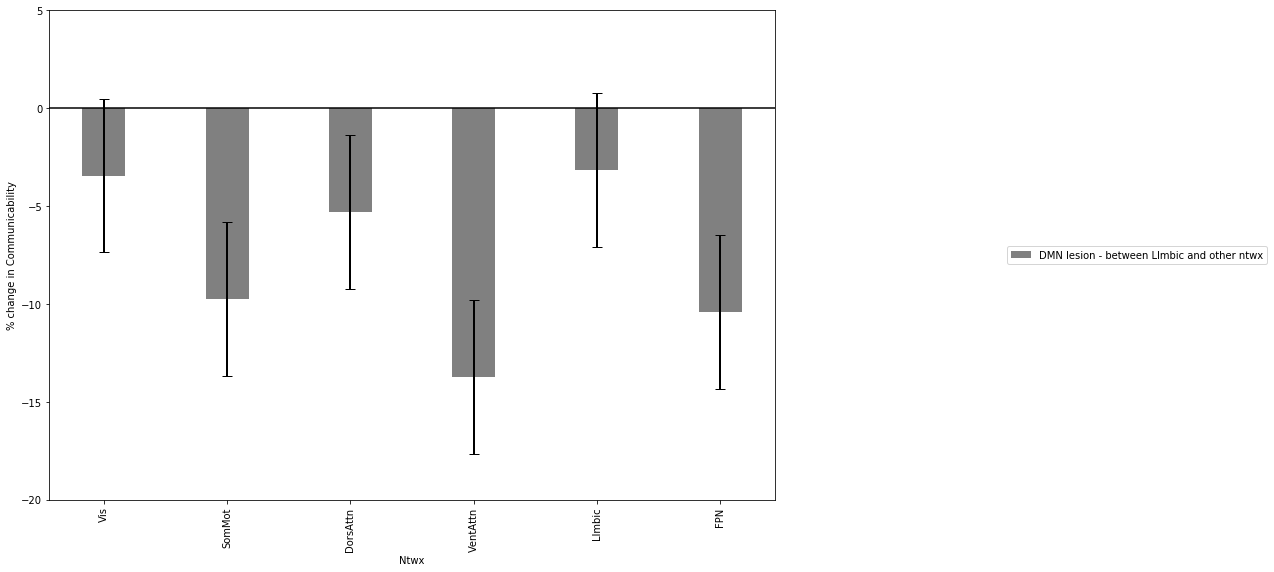

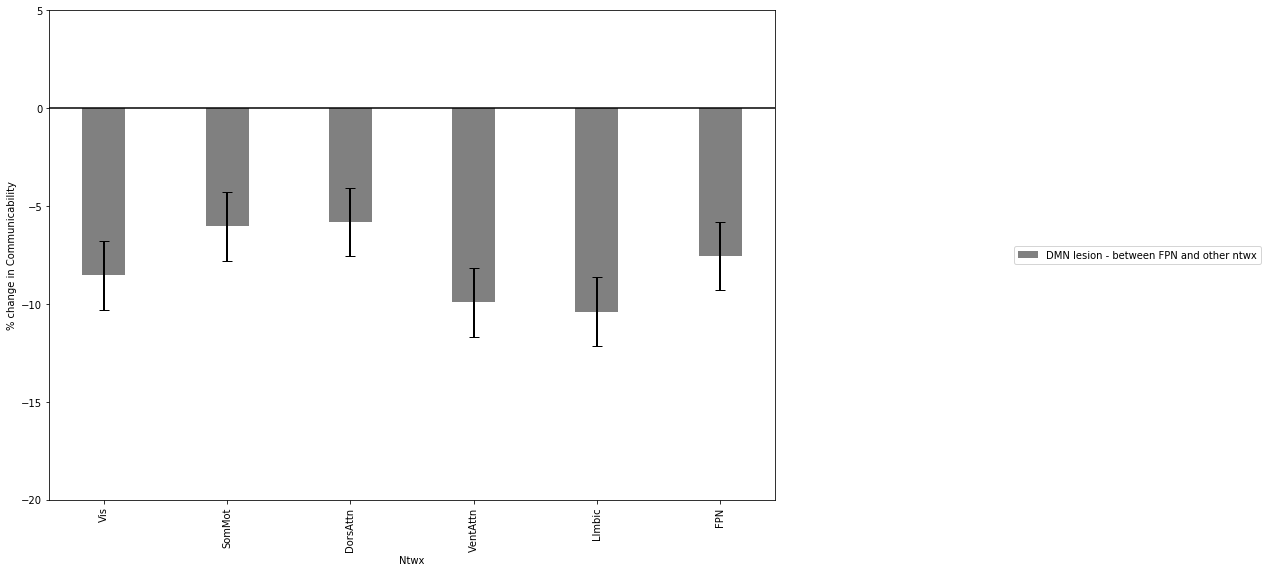

In [565]:
x = range(6)
width = 0.35
for i in range(7):
    if i !=6:
        fig, ax = plt.subplots(figsize=(13,9))
        error_values = np.std(percent_change_all_ntwx[i])
        rects1 = ax.bar(x,percent_change_all_ntwx[i],width,label='DMN lesion - between {0} and other ntwx'.format(Ntwx_labels22[i]),color='grey')#,color=hex_codes[1:])
        ax.errorbar(x, percent_change_all_ntwx[i], yerr=error_values, fmt='none', ecolor='black', elinewidth=2, capsize=5)
        ax.set_xlabel('Ntwx')
        ax.set_ylabel('% change in Communicability')
        ax.set_xticklabels(Ntwx_labels2)
        plt.ylim([-20,5])
        plt.xticks(rotation=90)
        ax.axhline(0, color='black', linestyle='-')
        ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

In [558]:
all_lesions_ntwx_ = [vis_lesion_between_other_ntwx,
smt_lesion_between_other_ntwx,
dan_lesion_between_other_ntwx,
van_lesion_between_other_ntwx,
lim_lesion_between_other_ntwx,
fpn_lesion_between_other_ntwx,
dmn_lesion_between_other_ntwx]

In [506]:
def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
#     percent_drop_means = []
#     for k in range(7):
#         if k!=idx:
#             percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
#     percent_drop_stds = []
#     for m in range(7):
#         if m!=idx:
#             percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_change_all_ntwx_lesion

In [507]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_between_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(smt_lesion_between_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dan_lesion_between_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(van_lesion_between_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(lim_lesion_between_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_between_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_between_other_ntwx,6)

In [508]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [509]:
for i in range(7):
    print(Ntwx_labels[i], 'lesion')
    for j in range(7):
        print(percent_change_all_ntwx_all_vals[i][j])
        print('')
    print('------------------------------------------------------------------------')

Vis lesion
[-1.1516130432049743, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]

[-100.0, -0.013133049231100945, -0.35248254944988017, -0.043398410801363814, -2.2784212600175033, -0.2821803829912354, -0.6273552607986068]

[-100.0, -0.35248254944988017, -1.7174879728358783, -0.6557978118830841, -6.306774001448477, -1.0140198185089373, -2.575440833648518]

[-100.0, -0.043398410801363814, -0.6557978118831037, -0.053419655698537384, -1.598833083764712, -0.16535160658735357, -0.2863146766342575]

[-100.0, -2.2784212600174887, -6.306774001448523, -1.5988330837647322, -1.0460503593930233, -1.056330335182307, -1.4714091300142187]

[-100.0, -0.2821803829912354, -1.0140198185089373, -0.16535160658738646, -1.0563303351822917, -0.15560674498070173, -0.40309066225859513]

[-100.0, -0.6273552607985655, -2.575440833648518, -0.2863146766342728, -1.4714091300142187, -0.40309066225859513, -0.4416792887418587]

------------------------------------------------------------------------
SomMot lesion
[-0.00

In [477]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
#     percent_drop_means = []
#     for k in range(7):
#         if k!=idx:
#             percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
#     percent_drop_stds = []
#     for m in range(7):
#         if m!=idx:
#             percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
#     return percent_drop_means, percent_drop_stds

    return percent_change_all_ntwx_lesion

In [472]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
    for j in range(7):
        if j!=idx:
            del percent_change_all_ntwx_lesion[j][idx]
    
    percent_drop_means = []
    for k in range(7):
        if k!=idx:
            percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
    percent_drop_stds = []
    for m in range(7):
        if m!=idx:
            percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_drop_means, percent_drop_stds

In [478]:
percent_change_vis = mean_percent_drops(vis_lesion_between_other_ntwx,0)
percent_change_smt = mean_percent_drops(smt_lesion_between_other_ntwx,1)
percent_change_dan = mean_percent_drops(dan_lesion_between_other_ntwx,2)
percent_change_van = mean_percent_drops(van_lesion_between_other_ntwx,3)
percent_change_lim = mean_percent_drops(lim_lesion_between_other_ntwx,4)
percent_change_fpn = mean_percent_drops(fpn_lesion_between_other_ntwx,5)
percent_change_dmn = mean_percent_drops(dmn_lesion_between_other_ntwx,6)

In [479]:
print(percent_change_vis[0][0])
print(percent_change_smt[1][1])
print(percent_change_dan[2][2])
print(percent_change_van[3][3])
print(percent_change_lim[4][4])
print(percent_change_fpn[5][5])
print(percent_change_dmn[6][6])

-1.1516130432049743
-3.757485727926533
-10.455830229437927
-12.203150973505334
-6.320523828935743
-11.548254129931898
-7.187554380588436


In [480]:
np.mean([-1.1516130432049743,
-3.757485727926533,
-10.455830229437927,
-12.203150973505334])

-6.8920199935186925

In [481]:
np.std([-1.1516130432049743,
-3.757485727926533,
-10.455830229437927,
-12.203150973505334])

4.574014448534187

In [482]:
np.mean([-6.320523828935743,
-11.548254129931898,
-7.187554380588436])

-8.352110779818693

In [483]:
np.std([-6.320523828935743,
-11.548254129931898,
-7.187554380588436])

2.287565624593015

In [473]:
percent_change_vis_mean, percent_change_vis_std = mean_percent_drops(vis_lesion_between_other_ntwx,0)
percent_change_smt_mean, percent_change_smt_std = mean_percent_drops(smt_lesion_between_other_ntwx,1)
percent_change_dan_mean, percent_change_dan_std = mean_percent_drops(dan_lesion_between_other_ntwx,2)
percent_change_van_mean, percent_change_van_std = mean_percent_drops(van_lesion_between_other_ntwx,3)
percent_change_lim_mean, percent_change_lim_std = mean_percent_drops(lim_lesion_between_other_ntwx,4)
percent_change_fpn_mean, percent_change_fpn_std = mean_percent_drops(fpn_lesion_between_other_ntwx,5)
percent_change_dmn_mean, percent_change_dmn_std = mean_percent_drops(dmn_lesion_between_other_ntwx,6)

#### vis

In [490]:
_yy = [percent_change_vis_mean[0:3], percent_change_smt_mean[0:3], percent_change_dan_mean[0:3], percent_change_van_mean[0:3]]

In [496]:
print('LON <-> LON')

print(np.mean(_yy))

print(np.min(_yy))

print(np.max(_yy))

print(np.std(_yy))

LON <-> LON
-2.4901390300425135
-5.774019561311243
-0.46718587422822133
1.8135881925442914


In [497]:
_dd = [percent_change_vis_mean[4:6], percent_change_smt_mean[4:6], percent_change_dan_mean[4:6], percent_change_van_mean[4:6]]

In [499]:
print('LON <-> HON')

print(np.mean(_dd))

print(np.min(_dd))

print(np.max(_dd))

print(np.std(_dd))

LON <-> HON
-1.8683235233649422
-4.073289892545394
-0.5127632584181913
1.2484992561734358


In [474]:
print(percent_change_vis_mean)

[-0.5994951522149484, -2.103667164629129, -0.46718587422822133, -2.2929696949700493, -0.5127632584181913, -0.9675483086826714]


In [475]:
print(percent_change_vis_std)

[0.7782819809715551, 2.0161066606473717, 0.5463235431611859, 1.8417251333185298, 0.37863251262119973, 0.8179400274588796]


In [476]:
print(np.mean(percent_change_vis_mean[0:3]))
print(np.mean(percent_change_vis_mean[3:6]))

-1.056782730357433
-1.257760420690304


#### smt

In [231]:
print(percent_change_smt_mean)

[-0.5200263611101326, -1.8057723298576143, -2.6650177642562065, -0.4251627891314413, -0.7268446943998302, -0.5989029550250491]


In [431]:
print(percent_change_smt_std)

[0.728554317306236, 1.5707160646863638, 1.4018959864284377, 0.5255768034148762, 0.640130982568219, 0.514408899233192]


In [238]:
print(np.mean(percent_change_smt_mean[0:3]))
print(np.mean(percent_change_smt_mean[3:6]))

-1.6636054850746511
-0.5836368128521069


#### dan

In [239]:
print(percent_change_dan_mean)

[-5.774019561311243, -4.74912837907224, -2.941137098160454, -2.8039062781258424, -4.073289892545394, -2.7422115366331314]


In [432]:
print(percent_change_dan_std)

[2.742351406263238, 2.368978576865912, 1.5519413264098298, 1.6403940541556985, 2.834258209092142, 1.721843762102173]


In [240]:
print(np.mean(percent_change_dan_mean[0:3]))
print(np.mean(percent_change_dan_mean[3:6]))

-4.488095012847979
-3.206469235768123


#### van

In [241]:
print(percent_change_van_mean)

[-1.0820891822090812, -5.430065987808809, -1.74406350565208, -1.672630770296176, -2.5634486931202187, -2.7615788480950525]


In [433]:
print(percent_change_van_std)

[1.5877332852028594, 2.209573166831133, 1.082836870442236, 2.5517011652709622, 2.028109590904582, 2.6004868187790944]


In [242]:
print(np.mean(percent_change_van_mean[0:3]))
print(np.mean(percent_change_van_mean[3:6]))

-2.75207289188999
-2.3325527705038156


In [501]:
_bb = [percent_change_lim_mean[4:6], percent_change_fpn_mean[4:6], percent_change_dmn_mean[4:6]]

In [502]:
print('HON <-> HON')

print(np.mean(_bb))

print(np.min(_bb))

print(np.max(_bb))

print(np.std(_bb))

HON <-> HON
-4.039400970465053
-8.044418862875974
-0.4609889614116169
3.030945647110642


In [503]:
_hh = [percent_change_lim_mean[0:4], percent_change_fpn_mean[0:4], percent_change_dmn_mean[0:4]]

In [505]:
print('HON <-> LON')

print(np.mean(_hh))

print(np.min(_hh))

print(np.max(_hh))

print(np.std(_hh))

HON <-> LON
-2.87231535096632
-7.4902095831235505
-0.20289593137178005
2.2163165801489746


#### lim

In [243]:
print(percent_change_lim_mean)

[-0.8378094136026766, -0.20289593137178005, -0.2819607887067941, -0.2764319849170758, -0.4609889614116169, -0.5511534577430056]


In [434]:
print(percent_change_lim_std)

[0.4067126209714399, 0.26918996675052653, 0.21408875465285473, 0.3597694601754595, 0.4105283108255914, 0.3126038662504224]


In [244]:
print(np.mean(percent_change_lim_mean[0:4]))
print(np.mean(percent_change_lim_mean[4:6]))

-0.3997745296495816
-0.5060712095773112


#### fpn

In [245]:
print(percent_change_fpn_mean)

[-1.722651521142021, -2.6490294818680784, -3.4188918395881287, -3.631367086121918, -3.054554797714245, -4.489469132923179]


In [436]:
print(percent_change_fpn_std)

[1.0752588445731317, 1.8035130413731437, 1.6691131556655867, 1.6739211892193988, 1.6335112437700368, 1.5439941637317174]


In [246]:
print(np.mean(percent_change_fpn_mean[0:4]))
print(np.mean(percent_change_fpn_mean[4:6]))

-2.8554849821800365
-3.772011965318712


#### dmn

In [247]:
print(percent_change_dmn_mean)

[-5.4562610270174465, -4.555218076889233, -3.9450574772471345, -7.4902095831235505, -7.635820610122294, -8.044418862875974]


In [437]:
print(percent_change_dmn_std)

[3.40647058335374, 3.625392520702631, 1.6733402928249832, 3.969996942260288, 3.9277853871654815, 1.759129269311829]


In [438]:
print(np.mean(percent_change_dmn_mean[0:4]))
print(np.mean(percent_change_dmn_mean[4:6]))

-5.361686541069341
-7.840119736499133
